In [1]:
import torch
import torch.nn as nn
import random 
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import time
from torch_geometric.utils import to_scipy_sparse_matrix
from scipy.sparse.csgraph import connected_components
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import scatter

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
gdoc.setNoScroll()


<IPython.core.display.Javascript object>

In [3]:
from torch_geometric.nn import aggr

In [4]:
torch.__version__


'2.4.0'

In [5]:

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")



####  DATA


MaterPointProcess_0_99 
<br>
Simule un double procédé de poisson d'abord sur la fenetre carrée etendue puis sur un cercle 
<br>
ci dessous plus de détails :  
https://hpaulkeeler.com/simulating-a-matern-cluster-point-process/
<br>
Return un dataframe panda avec deux colonnes pour les coordonnées des points   

<br>
Tous les echantillons créés avec les mêmes paramètres d'entrée pourront être de tailles différentes


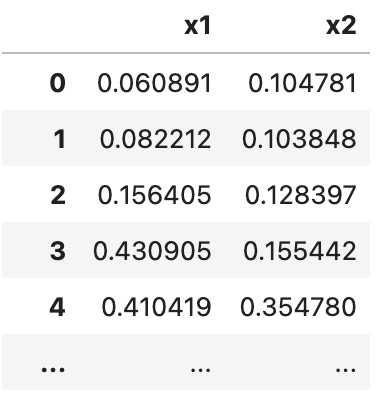

In [6]:

def MaterPointProcess_0_99(lambdaParent,lambdaDaughter,radiusCluster,plot=False):

    # Simulation window parameters
    xMin = 0;
    xMax = 1;
    yMin = 0;
    yMax = 1;

    # Extended simulation windows parameters
    rExt = radiusCluster;  # extension parameter -- use cluster radius
    xMinExt = xMin - rExt;
    xMaxExt = xMax + rExt;
    yMinExt = yMin - rExt;
    yMaxExt = yMax + rExt;

    # rectangle dimensions
    xDeltaExt = xMaxExt - xMinExt;
    yDeltaExt = yMaxExt - yMinExt;
    areaTotalExt = xDeltaExt * yDeltaExt;  # area of extended rectangle

    # Simulate Poisson point process for the parents
    numbPointsParent = np.random.poisson(areaTotalExt * lambdaParent);  # Poisson number of points
    
    # x and y coordinates of Poisson points for the parent
    xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);

    # Simulate Poisson point process for the daughters (ie final poiint process)
    numbPointsDaughter = np.random.poisson(lambdaDaughter*np.pi*((radiusCluster)**2), numbPointsParent);
    #l'aire du cercle étant <1 cela nuit gravement au résultat à utiliser en fonction des valeurs des paramètres
    numbPoints = sum(numbPointsDaughter);

    # Generate the (relative) locations in polar coordinates by
    # simulating independent variables.
    theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints);  # angular coordinates
    rho = radiusCluster * np.sqrt(np.random.uniform(0, 1, numbPoints));  # radial coordinates
    # Convert from polar to Cartesian coordinates
    xx0 = rho * np.cos(theta);
    yy0 = rho * np.sin(theta);

    # replicate parent points (ie centres of disks/clusters)
    xx = np.repeat(xxParent, numbPointsDaughter);
    yy = np.repeat(yyParent, numbPointsDaughter);

    # translate points (ie parents points are the centres of cluster disks)
    xx = xx + xx0;
    yy = yy + yy0;

    # thin points if outside the simulation window
    booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax));
    # retain points inside simulation window
    xx = xx[booleInside];
    yy = yy[booleInside];

    # keeping the same digits precision as the simtub
    data = {'x1': xx, 'x2': yy}
    echantillon = pd.DataFrame(data)
    #echantillon = echantillon.astype(int)

    if plot:
            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

            # First scatter plot
            axs[0].scatter(xx, yy, edgecolor='b', facecolor='none', alpha=0.5)
            axs[0].set_xlim([0, 1])
            axs[0].set_ylim([0, 1])
            axs[0].set_xlabel('x')
            axs[0].set_ylabel('y')
            axs[0].axis('equal')

            # Heatmap data
            heatmap_data = echantillon.pivot_table(index='x2', columns='x1', values='Simu')

            # Second heatmap plot
            cax = axs[1].imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
            fig.colorbar(cax, ax=axs[1], label='Simu')
            axs[1].scatter(echantillon['x1'], echantillon['x2'], color='red', s=10)
            axs[1].set_xlabel('x1')
            axs[1].set_ylabel('x2')
            axs[1].set_title('Simu Values with Selected Points')

            plt.show()

    return(echantillon)

###  Créer_edge_graph


Prends en entrée un dataframe avec les coordonnées et la valeur prise par la réalisation pour chaque point

Créé un graph afin que le nombre maximum de voisins en tout point soit max_neighbors sont mis voisins deux points situés moins loin que threshold

Est mis en attribut d'arrête (=edge_attr) pour chaque point ladite distance entre les deux sommets de l'arrête

Return ledit graph 



In [7]:


def créer_edge_graph(echantillon, threshold, max_neighbors):
    edge_sources = []
    edge_destinations = []
    edge_features = []
    edge_attr=[]
    for i in range(len(echantillon)):
        distances = []
        for j in range(len(echantillon)):
            if i != j:
                dist = np.sqrt((echantillon.iloc[i]['x1'] - echantillon.iloc[j]['x1'])**2 + 
                               (echantillon.iloc[i]['x2'] - echantillon.iloc[j]['x2'])**2)
                if dist < threshold:
                    distances.append((dist, j))

        #distances = sorted(distances, key=lambda x: x[0])[:max_neighbors]
        if len(distances) > max_neighbors:
            distances = random.sample(distances, max_neighbors)

        for dist, j in distances:
            if (i, j) not in zip(edge_sources, edge_destinations):
                edge_sources.append(i)
                edge_destinations.append(j)
                edge_features.append(dist)
            if (j, i) not in zip(edge_sources, edge_destinations):
                edge_sources.append(j)
                edge_destinations.append(i)
                edge_features.append(dist)

    edge_index = torch.tensor([edge_sources, edge_destinations], dtype=torch.long)
    edge_features = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)  # Convert to tensor and reshape

    node_features = torch.tensor(echantillon[['Simu']].values, dtype=torch.float)
    #node_features = torch.cat([node_features, torch.zeros((node_features.size(0), 1), dtype=torch.float)], dim=1)
    
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
    #data.D=torch.tensor(edge_features, dtype=torch.float)#.view(-1, 1)  # Convert to tensor and reshape
    return data


###  simu_echantillonage_graph

Crée un graph selon ce process :

1- Réalise le Matern Point Process pour extraire les coordonnées des points du graph
<br>
2- Ajoute une colonne 'Simu' au datframe contenant la réalisation de Matern en chaque point
<br>
3- Utilise créer_edge_graph fonction ci dessus pour faire le graph avec la vameur de Simu en node attribute et la distance entre deux points en edge attribute
<br>

return un graph avec une seule composante, et dont tous les points sont reliés

In [8]:

def simu_echantillonage_graph(range,param_model,lambdaParent,lambdaDaughter,radiusCluster,threshold,max_neighbors):

    echantillon_a=MaterPointProcess_0_99(lambdaParent,lambdaDaughter,radiusCluster,plot=False)#(100,50,0.10,False)
    db = gl.Db_fromPanda(echantillon_a)
    db.setLocators(["x1","x2"],gl.ELoc.X)

    model = gl.Model.createFromParam(type=gl.ECov.BESSEL_K, range = range, param = param_model)  # comment rajouter la NUGGET si il ne prends pas de typeS ?
    err = gl.simtub(None, db, model, None, nbsimu=1, seed=0, nbtuba = 1000) #seed=0 lance à chaque fois une simu différente
    #err = gl.Model.addCovFromParam(model,type=gl.ECov.NUGGET, sill = 1) ##Ajouter un nugget de variance 1

    df=pd.DataFrame({'Simu': db['z1']})
    echantillon_a = pd.concat([echantillon_a, df],axis=1)
    #print(echantillon_a)
    data=créer_edge_graph(echantillon_a,threshold,max_neighbors) #threshold=0.4 max_neighbors=10
    return(data)


### merge_components


Prends en entrée une liste de x graphs

Permets de fusionnés tous les graphs d'un même Deepset en un seul graph à x composantes non connexes
x est la taille du deepset.  x=deepset_size

Cette fonction est cruciale pour la création du jeu de données puisque elle s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

Le graph fusionné ce voit rajouté un attribut T attribut global qui contient le nombre de noeuds de chaque sous graph.

In [9]:

def merge_components(components,deepset_size):
    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    T=torch.empty(deepset_size)
    D=[]
    for component in components:
                
        component.edge_index,component.edge_attr = torch_geometric.utils.coalesce(component.edge_index,component.edge_attr,reduce='mean', is_sorted=True)
        x_list.append(component.x)
        edge_index_list.append(component.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(component.edge_attr)
        num_nodes_offset += component.num_nodes
        T[i]=component.num_nodes
        #D+=(component.d)
        i+=1
    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    #edge_attr_list = torch.tensor(edge_attr_list, dtype=torch.float)
    #print(edge_attr_list)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index,edge_attr1=edge_attr)# edge_attr=edge_attr)
    graph.T=T
    return graph


###  simu_graph

Fonction qui crée un gros graph avec deepset_size composantes non connexes selon les paramètres d'une réalisation de Matern

Le graph se voit ajouter sa target data.y contenant les deux paramètres de la fonction de Matérn que l'on cherche à estimer


In [10]:

def simu_graph(deepset_size, range_val, param_model, lambdaParent, lambdaDaughter, radiusCluster, threshold, max_neighbors):
    data = [simu_echantillonage_graph(range_val, param_model, lambdaParent, lambdaDaughter, radiusCluster, threshold, max_neighbors) for i in range(int(deepset_size))]
    data=merge_components(data,deepset_size)
    data.y=torch.log(torch.tensor((range_val,param_model)))
    
    return data


###  composante_non_connexes


Fonction de vérification utile pour connaître le nombre de composantes non connexes d'un graph

In [11]:

def composante_non_connexes(data):
    adj_matrix = to_scipy_sparse_matrix(data.edge_index)
    num_components, labels = connected_components(adj_matrix, directed=False)
    print(f"Le graphe contient {num_components} composante(s) connexe(s).")
    return(num_components)

###  datamaker

Fonction qui créé le jeu de données avec n graphes composés chacun de deepset_size sous graphes

Les listes L et M sont utilisé dans la phase de test pour un modèles où n=4 ou moins

In [66]:


#L=[0.3,0.3,0.5,0.5]
#M=[0.7,0.7,0.5,0.5]
#L=[(0.3) for i in range(10)]+[(0.5) for i in range(10)]
#M=[(0.7) for i in range(10)]+[(0.5) for i in range(10)]


def datamaker(constant_product,n,deepset_size):

    
    datalist=[]
    range_list=np.random.uniform(0.05,0.5,n)
    variance_list=np.random.uniform(0.0,1.0,n)
    lambdaParent = np.random.uniform(50, 150,n)
    lambdaDaughter =[ (constant_product / lambdaParent[i]) for i in range(n) ]

    
    for i in range(n): 
        
        datalist.append(simu_graph(deepset_size,range_list[i],variance_list[i],lambdaParent[i],lambdaDaughter[i],0.10,0.4,10))         
        
        # pour les exemples de check avec des valeur de y qui sont fixées par les listes L et M
        #datalist.append(simu_graph(deepset_size,L[i],M[i],lambdaParent[i],lambdaDaughter[i],0.10,0.4,10))         

    print(f" Generated dataset size: {n * deepset_size}")
    
    return datalist


# Création des données

In [67]:

constant_product=7000
n=20
deepset_size=5
datalist=datamaker(constant_product,n,deepset_size)


 Generated dataset size: 100


In [68]:
datalist

[Data(x=[1168, 1], edge_index=[2, 10931], edge_attr1=[10931, 1], T=[5], y=[2]),
 Data(x=[1027, 1], edge_index=[2, 9470], edge_attr1=[9470, 1], T=[5], y=[2]),
 Data(x=[1015, 1], edge_index=[2, 9395], edge_attr1=[9395, 1], T=[5], y=[2]),
 Data(x=[1059, 1], edge_index=[2, 9885], edge_attr1=[9885, 1], T=[5], y=[2]),
 Data(x=[1057, 1], edge_index=[2, 9790], edge_attr1=[9790, 1], T=[5], y=[2]),
 Data(x=[1121, 1], edge_index=[2, 10486], edge_attr1=[10486, 1], T=[5], y=[2]),
 Data(x=[1149, 1], edge_index=[2, 10759], edge_attr1=[10759, 1], T=[5], y=[2]),
 Data(x=[1131, 1], edge_index=[2, 10561], edge_attr1=[10561, 1], T=[5], y=[2]),
 Data(x=[1173, 1], edge_index=[2, 11010], edge_attr1=[11010, 1], T=[5], y=[2]),
 Data(x=[1002, 1], edge_index=[2, 9281], edge_attr1=[9281, 1], T=[5], y=[2]),
 Data(x=[1072, 1], edge_index=[2, 10019], edge_attr1=[10019, 1], T=[5], y=[2]),
 Data(x=[1101, 1], edge_index=[2, 10244], edge_attr1=[10244, 1], T=[5], y=[2]),
 Data(x=[1115, 1], edge_index=[2, 10437], edge_att

In [69]:
class GraphSetDataset(Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        return self.datalist[idx]


### Fonction collate pour gérer l'assemblage des graphes lors du batching

Dans la même idée que merge_components on s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

En effet lors du batching le loader de PyG fait des données (qu'il suppose être des graphes simples) d'un même batch un gros graph à composante non connexes.

In [70]:
def collate_fn(batch):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    labels = torch.empty(len(batch),2)
    
    for allset, label in batch:
        labels.append(label)
        x_list.append(allset.x)
        edge_index_list.append(allset.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(allset.edge_attr)
        num_nodes_offset += allset.num_nodes


    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    labels = torch.tensor( labels,dtype=torch.float32)

    return graph, labels

In [71]:
dataset = GraphSetDataset(datalist)

batch_size = 4

loader = DataLoader(dataset, batch_size, collate_fn=collate_fn, shuffle=True)

In [72]:
dataset.__getitem__(0)

Data(x=[1168, 1], edge_index=[2, 10931], edge_attr1=[10931, 1], T=[5], y=[2])

In [73]:
dataset.__getitem__(0).y

tensor([-0.8988, -0.1958], dtype=torch.float64)

In [74]:
dataset.__getitem__(15).y
dataset.__getitem__(13).y

tensor([-2.9431, -2.1172], dtype=torch.float64)

In [75]:
dataset.__getitem__(8).y

tensor([-0.7912, -0.5434], dtype=torch.float64)

## Fin de la partie de création des données



In [76]:


def find_duplicate_edges_with_attr(edge_index, edge_attr1):
    assert edge_index.size(1) == edge_attr1.size(0), "edge_index and edge_attr must have the same length."

    sorted_edge_index, sort_indices = torch.sort(edge_index, dim=0)
    sorted_edge_attr1 = edge_attr1[sort_indices[0]]  # Tri des attributs d'arête selon le même ordre

    edge_pairs = sorted_edge_index.t()
    edge_with_attr = torch.cat([edge_pairs, sorted_edge_attr1], dim=1)
    unique_edges, counts = torch.unique(edge_with_attr, dim=0, return_counts=True)

    duplicates = unique_edges[counts > 1]

    return duplicates

print("Duplicated edges (including edge_attr1):", len(find_duplicate_edges_with_attr(datalist[1].edge_index, datalist[1].edge_attr1)))





Duplicated edges (including edge_attr1): 0


# Création du model


### one_hot_encode_distance

Prends en entrée distance et threshold qui est la distance max de deux voisins

Fonction qui encode dans un tensor de taille 10  à quel dixeme de la distance max appartient distance

Fonction qui sera appliquée à tous les edges_attr

In [77]:

def one_hot_encode_distance(threshold, distance, epsilon=1e-5):
    if distance < epsilon or distance > threshold:
        raise ValueError(distance,threshold,"Distance should be within the range (0, threshold]")
    
    interval_length = threshold / 10
    interval_index = int(distance / interval_length)
    if interval_index == 10:
        interval_index = 9
    
    one_hot = torch.zeros(10, device=device)
    one_hot[interval_index] = 1
    
    return one_hot

In [78]:
one_hot_encode_distance(0.4,0.34)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [79]:
class expact(nn.Module):
    def forward(self, x):
        return torch.exp(x)
        


In [80]:
class EdgeFeatureMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_output_dim):
        super(EdgeFeatureMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_output_dim)
            #nn.Relu() #enlevé à checker
        ).to(device) 

    def forward(self, x):
        return self.mlp(x)
    

In [81]:
   
class MappingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MappingLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)#,
            #expact()
            #enlever dans le cas où on s'intéresse desormais au log des  target classiques parametres kappa sigma à check
        )

    def forward(self, pooled_feature):
        device=pooled_feature.device
        out = self.mlp(pooled_feature.to(device))
        return out


In [82]:
class Couchewtilde(nn.Module):
    def __init__(self, in_channels, edge_hidden_dim, edge_output_dim, threshold):
        super(Couchewtilde, self).__init__()
        
        self.edge_mlp = EdgeFeatureMLP(in_channels, edge_hidden_dim, edge_output_dim)
        self.threshold = threshold
    
    def forward(self, data):

        #on veut mettre en edge attr wtilde en plus des simple distances
        # - le mettre dans le meme vecteur ou esssayer un tensor ?
        x, edge_index, edge_attr1 = data.x.to(device), data.edge_index.to(device), data.edge_attr1.to(device)
        #print('edge_attr1',edge_attr1.size())        
        mlp_output = self.edge_mlp(edge_attr1)
        #print('mlp_output',mlp_output.size())
        #essayer de faire disparaitre la boucle for cachée
        one_hot_features = torch.stack([one_hot_encode_distance(self.threshold, d.item()) for d in edge_attr1]).to(device)
        #print('one_hot_features',one_hot_features)
        #print('mlp_output',mlp_output)
        #print('mlp_output',mlp_output[45])
        w = torch.cat((one_hot_features, mlp_output), dim=1)        
        #print('w[45]',w[45])
        #print('normalement de taille 20 avec dabord le onehot puis mlpoutput',w.size())
        d = scatter(w, edge_index[0],reduce = 'sum') #sum over all neighbors
        #print('d[45] apres scatter_sum',d[45]) n'a aucun sens car size de d est le nb de noeudsx20
        #print('d size',d.size())
        #print('d après scatter',d)
        #print('d size après scatter',d.size())
        #d size après scatter torch.Size([nb de noeuds, 20])
        dtilde = d[edge_index[0]]  #### CHECK: on veut créer un vecteur comme edge_index[0] avec la valeur de d correspondante à chaque index)
        #print('dtilde[45]',dtilde[45])#.size())
        mask = dtilde != 0
        #print(mask[45])
        #edge_attr_j = edge_attr_combined[torch.nonzero((edge_index[0] == j) & (edge_index[1] == j_prime), as_tuple=True)].view(-1)
        replacement_tensor = torch.full((1, 20), 1e-5, device=device)
        wtilde = torch.where(mask, w / dtilde, replacement_tensor)    
        #wtilde = w / dtilde ### CHECK problème revoye parfois des 0 donc on ne peut pas diviser par 0
        #print('wtilde',wtilde.size())
        #print('wtilde_45',wtilde[45])
        data.edge_attrwtilde=wtilde
        #print('data',data)
        return data

In [83]:
class SpecialConv(MessagePassing):  ## created from CGConv
    # in edge attribute there is d_ij and wtilde_ij forall i,j (2D Tensor)
    
    def __init__(self, hidden_channels, moovingvaluegamma1):
        super().__init__(aggr='add')
        self.a = nn.Parameter(torch.rand(1, device=device)) # a in [0, 1]
        self.b = nn.Parameter(torch.rand(1, device=device) + 1) # b > 0
        self.gamma1 = nn.Parameter(torch.rand(hidden_channels, moovingvaluegamma1, device=device))
        self.gamma2 = nn.Parameter(torch.rand(hidden_channels, hidden_channels, device=device))
        self.biax = nn.Parameter(torch.rand(hidden_channels,1, device=device))
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_attr: torch.Tensor ) -> torch.Tensor:
        #print(x.size(),edge_attr.size())
        hbar = self.propagate(edge_index, x=x, edge_attr=edge_attr) ## vrai message passing
        #print('hbar.size()',hbar.size())
        hbar=hbar.transpose(1,0)
        #print('hbar.size()',hbar.size())
        
        #print('x.size()',x.size())
        x=x.transpose(1,0)
        #print('x.size()',x.size())
        #print('g1',self.gamma1.size())
        #print('g2',self.gamma2.size())

        #print('self.gamma1 @ x',(self.gamma1 @ x).size())
        #print('self.gamma2 @ hbar',(self.gamma2 @ hbar).size())

        #print(self.biax)
        #print(self.biax.size())
        out = self.gamma1 @ x + self.gamma2 @ hbar +  self.biax
        out=out.transpose(1,0)
        #out = torch.nn.functional.relu(out).squeeze() pb during backward->in place operation
        out = torch.nn.ReLU()(out).squeeze()

        return out

    def message(self, x_i, x_j, edge_attr: torch.Tensor) -> torch.Tensor:
        # on fait rho * wtilde (edge_attr[1])
        #
        rho = (torch.abs(self.a * x_i - (1 - self.a) * x_j)) ** self.b

        return rho * edge_attr


In [84]:

class DeepTEST(nn.Module):

    def __init__(self, in_channels, moovingvaluegamma1_1, moovingvaluegamma1_2, hidden_dim, edge_hidden_dim, edge_output_dim, threshold,mapping_hidden_dim, final_output_dim):# final_output_dim, mapping_hidden_dim, threshold):
        super(DeepTEST, self).__init__()
        
        self.Coucheinitialewtilde = Couchewtilde(in_channels, edge_hidden_dim, edge_output_dim, threshold)
        self.specialconv1 = SpecialConv(hidden_dim,moovingvaluegamma1_1)
        
        self.Coucheinterwtilde = Couchewtilde(in_channels, edge_hidden_dim, edge_output_dim, threshold)
        self.specialconv2 = SpecialConv(hidden_dim,moovingvaluegamma1_2)
        
        self.mapping = MappingLayer(hidden_dim, mapping_hidden_dim, final_output_dim)

    def forward(self, data):
        data = data.to(device)
        data_T=data.T.to(device)
        data_batch=data.T2.to(device)
        
        data = self.Coucheinitialewtilde(data)
        data.x = self.specialconv1(x=data.x, edge_index=data.edge_index, edge_attr= data.edge_attrwtilde)
        #print('postpremière couche',data)
        
        data=self.Coucheinterwtilde(data)
        data.x=self.specialconv2(x=data.x, edge_index=data.edge_index, edge_attr= data.edge_attrwtilde)
        #print('postdeuxieme couche',data)
        
        pooled_graphs = global_mean_pool(data.x, data_T) 
        #print('pooled_graphs',pooled_graphs)
        out=global_mean_pool(pooled_graphs, data_batch) 
        #print('out',out)
        output = self.mapping(out)
        output = output.view(-1)
        #print(output)
        return output

    
    


In [85]:
model = DeepTEST(in_channels=1,
                 moovingvaluegamma1_1=1,
                 moovingvaluegamma1_2=20 ,
                 hidden_dim=20,
                 edge_hidden_dim=128,
                 edge_output_dim=10,
                 threshold=0.40,
                 mapping_hidden_dim=128,
                 final_output_dim=2)
#in_channels=1, hidden_dim=20, edge_hidden_dim=128, edge_output_dim=10, final_output_dim=2, mapping_hidden_dim=128, threshold=0.40).to(device)

# Définition training

In [86]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train(model, optimizer, loader, n, batch_size, leave=False):
    model.train()
    MAE = torch.nn.L1Loss(reduction="mean")
    sum_loss = 0.0
    total = n // batch_size
    #t = tqdm(enumerate(loader), total=total, leave=leave)
    t=enumerate(loader)
    for i, batched_data in t:
        optimizer.zero_grad()

        T1 = []
        for j in range(len(batched_data.T)):
            T1.extend([j] * int(batched_data.T[j].item()))  
        batched_data.T = torch.tensor(T1, device=device)

        T2=[]
        for w in range(len(batched_data)):
            T2.extend([w] * deepset_size)
        batched_data.T2 = torch.tensor(T2, device=device)

        batched_data.y = batched_data.y.view(batch_size, 2) 
        batched_data = batched_data.to(device)

        output = model(batched_data)
        output=torch.reshape(output,(batch_size,2))
        print('outputdetrain',output)

        if output.size(0) != batch_size or output.size(1) != 2:
            raise ValueError(f"Expected output shape ({batch_size}, 2) but got {output.size()}")

        y_batch = batched_data.y.to(device)
        print('y_batch de train avant MAE',y_batch)  ## ybatch est sur le log des parametres classique
        batch_loss = MAE(output, y_batch)
        
        #print('training...')
        batch_loss.backward()
        optimizer.step()

        sum_loss += batch_loss.item()
        t.set_description(f"loss = {batch_loss.item():.5f}")
        t.refresh()

    return sum_loss / (i + 1)



In [87]:
torch.autograd.set_detect_anomaly(False)

# Epochs

start of epoch: 1/80


loss = 8.16897:  20%|█████▊                       | 1/5 [00:00<00:02,  1.99it/s]

outputdetrain tensor([[ -5.2992,  -3.2426],
        [ -5.6091,  -3.4098],
        [ -6.3863,  -3.8403],
        [-32.8207, -19.2694]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.6971, -1.0637],
        [-0.8778, -0.9963],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 3.88157:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.20it/s]

outputdetrain tensor([[-7.0656, -4.0602],
        [-6.6808, -3.8211],
        [-5.8610, -3.3863],
        [-6.9403, -4.0006]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.5190, -1.4573],
        [-0.9581, -0.0507],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 3.07595:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.30it/s]

outputdetrain tensor([[-6.2505, -3.3453],
        [-5.8712, -3.1821],
        [-5.5089, -2.9587],
        [-4.4956, -2.4676]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 2.58610:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.36it/s]

outputdetrain tensor([[-6.2099, -3.0516],
        [-4.8457, -2.4269],
        [-3.8736, -1.9310],
        [-5.0026, -2.4674]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-0.8752, -2.1327]], dtype=torch.float64)


outputdetrain tensor([[-4.7040, -2.0866],
        [-4.7904, -2.1218],
        [-4.1046, -1.7798],
        [-5.5799, -2.4415]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.5617, -0.3069],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 4.000086869050714
start of epoch: 2/80


loss = 1.37569:  20%|█████▊                       | 1/5 [00:00<00:01,  2.36it/s]

outputdetrain tensor([[-3.9523, -1.4211],
        [-2.9060, -1.0784],
        [-2.8241, -1.0606],
        [-2.9758, -1.1318]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.7927, -0.2188],
        [-0.8988, -0.1958],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 3.41104:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.63it/s]

outputdetrain tensor([[ -3.4106,  -0.9559],
        [-14.4985,  -3.4073],
        [ -3.0026,  -0.8700],
        [ -3.0943,  -0.8553]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.9872, -8.8090],
        [-1.2543, -0.2374],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.85484:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-2.2986, -0.5646],
        [-2.4991, -0.6654],
        [-3.0840, -0.7712],
        [-2.3548, -0.6044]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.0951, -1.2857],
        [-2.3545, -0.1553],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.84033:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.42it/s]

outputdetrain tensor([[-1.8554, -0.4528],
        [-1.6201, -0.3853],
        [-1.9041, -0.4745],
        [-1.9176, -0.4600]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.8778, -0.9963],
        [-2.9431, -2.1172],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.0368, -0.3005],
        [-1.1855, -0.3369],
        [-1.3776, -0.3407],
        [-0.9216, -0.2844]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.9958, -0.3870],
        [-2.9085, -0.7003],
        [-0.6971, -1.0637]], dtype=torch.float64)
loss: 1.398457189019044
start of epoch: 3/80


loss = 0.60398:  20%|█████▊                       | 1/5 [00:00<00:01,  2.39it/s]

outputdetrain tensor([[-0.5762, -0.2735],
        [-0.6113, -0.2810],
        [-0.5699, -0.2602],
        [-0.6283, -0.3084]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.5190, -1.4573],
        [-0.8778, -0.9963],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.84628:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.38it/s]

outputdetrain tensor([[-0.1948, -0.3104],
        [-0.1935, -0.3099],
        [-0.2099, -0.3075],
        [-0.1566, -0.2559]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.3209, -0.3972],
        [-1.7493, -2.3891],
        [-0.8988, -0.1958]], dtype=torch.float64)


loss = 1.00799:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.40it/s]

outputdetrain tensor([[ 0.0643, -0.2680],
        [ 0.1024, -0.3310],
        [ 0.0189, -0.2603],
        [ 0.0497, -0.2766]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.3545, -0.1553],
        [-0.6971, -1.0637],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 2.15697:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[ 0.2854, -0.3231],
        [ 0.2439, -0.3228],
        [ 0.1045, -0.2661],
        [ 1.2785, -0.6363]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.0951, -1.2857],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[ 0.1342, -0.3854],
        [ 0.1842, -0.4114],
        [ 0.2475, -0.4674],
        [ 0.2566, -0.4878]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.9581, -0.0507],
        [-1.9958, -0.3870],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 1.196780766119009
start of epoch: 4/80


loss = 0.82980:  20%|█████▊                       | 1/5 [00:00<00:01,  2.53it/s]

outputdetrain tensor([[ 0.1040, -0.5186],
        [ 0.0991, -0.5054],
        [ 0.0812, -0.5185],
        [ 0.0505, -0.4595]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.9581, -0.0507],
        [-1.0657, -0.5529],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.59413:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[ 0.0874, -2.3279],
        [-0.0368, -0.7023],
        [-0.0380, -0.7189],
        [-0.0164, -0.6918]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.3209, -0.3972],
        [-1.5617, -0.3069],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 1.10966:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-0.3459, -0.9540],
        [-0.2386, -0.6900],
        [-0.3231, -0.7284],
        [-0.2924, -0.8994]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.7912, -0.5434],
        [-1.0751, -1.4696],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.84150:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-0.5104, -0.7384],
        [-0.7515, -1.1490],
        [-0.6197, -0.9973],
        [-0.5924, -0.9225]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-2.3545, -0.1553],
        [-1.9958, -0.3870],
        [-1.2543, -0.2374]], dtype=torch.float64)


outputdetrain tensor([[-1.0504, -1.0038],
        [-0.9127, -0.8370],
        [-0.7348, -0.7335],
        [-1.0157, -0.9612]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.8778, -0.9963],
        [-0.8988, -0.1958],
        [-1.5190, -1.4573]], dtype=torch.float64)
loss: 0.9745034368340633
start of epoch: 5/80


loss = 0.36468:  20%|█████▊                       | 1/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-1.3869, -1.0085],
        [-1.3888, -1.0480],
        [-1.2823, -0.9358],
        [-1.2277, -0.8772]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.9958, -0.3870],
        [-1.0657, -0.5529],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.77342:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-1.7780, -1.1235],
        [-1.5870, -1.0035],
        [-1.7936, -1.1072],
        [-1.6271, -0.9870]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.2543, -0.2374],
        [-1.5617, -0.3069],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 2.04889:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-8.7372, -4.2113],
        [-2.0690, -1.1403],
        [-2.0129, -1.1240],
        [-1.5066, -0.8841]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.7493, -2.3891],
        [-1.3209, -0.3972],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.71615:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.63it/s]

outputdetrain tensor([[-1.8201, -1.1214],
        [-1.5909, -0.9863],
        [-1.4917, -0.9410],
        [-1.5485, -0.9504]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.6971, -1.0637],
        [-0.8988, -0.1958],
        [-0.7927, -0.2188]], dtype=torch.float64)


outputdetrain tensor([[-1.8864, -1.1994],
        [-2.4555, -1.5903],
        [-2.0429, -1.3790],
        [-2.5253, -1.6506]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-2.9085, -0.7003],
        [-1.0951, -1.2857],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.9089187631311916
start of epoch: 6/80


loss = 0.69832:  20%|█████▊                       | 1/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-2.4415, -1.6530],
        [-2.1108, -1.4765],
        [-1.9658, -1.3425],
        [-2.0312, -1.4312]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.9958, -0.3870],
        [-0.8752, -2.1327],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.70530:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-1.4696, -1.0618],
        [-1.5436, -1.1331],
        [-1.5259, -1.0729],
        [-2.1193, -1.4831]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-0.7927, -0.2188],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 1.94809:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-2.0187, -1.5017],
        [-1.7954, -1.3311],
        [-8.5283, -5.6320],
        [-1.9685, -1.4414]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.54591:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.7653, -1.4903],
        [-1.8298, -1.5678],
        [-1.5912, -1.3021],
        [-2.1169, -1.7930]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.5617, -0.3069],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553]], dtype=torch.float64)


outputdetrain tensor([[-1.3770, -1.3057],
        [-1.4426, -1.3958],
        [-1.2011, -1.1800],
        [-1.3644, -1.3478]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.0657, -0.5529],
        [-0.6971, -1.0637],
        [-0.9581, -0.0507]], dtype=torch.float64)
loss: 0.8883282340124801
start of epoch: 7/80


loss = 0.65597:  20%|█████▊                       | 1/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-1.2188, -1.3843],
        [-1.0042, -1.1023],
        [-0.9980, -1.1635],
        [-1.3534, -1.5633]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-0.7912, -0.5434],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.64981:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.71it/s]

outputdetrain tensor([[-0.9801, -1.2405],
        [-1.1236, -1.3913],
        [-1.0562, -1.3099],
        [-1.2997, -1.6128]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-0.8752, -2.1327],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.47024:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.62it/s]

outputdetrain tensor([[-0.9049, -1.3254],
        [-0.8541, -1.1399],
        [-0.9471, -1.3506],
        [-0.9374, -1.3663]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8778, -0.9963],
        [-1.3209, -0.3972],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.65833:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.56it/s]

outputdetrain tensor([[-0.8108, -1.0063],
        [-0.9028, -1.2015],
        [-0.6345, -0.8668],
        [-0.9008, -1.2157]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-0.8988, -0.1958],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-0.8182, -0.9234],
        [-3.6532, -3.7989],
        [-1.0415, -1.1942],
        [-0.6882, -0.7918]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.9872, -8.8090],
        [-2.3545, -0.1553],
        [-0.6971, -1.0637]], dtype=torch.float64)
loss: 0.7600422563809135
start of epoch: 8/80


loss = 0.61296:  20%|█████▊                       | 1/5 [00:00<00:01,  2.37it/s]

outputdetrain tensor([[-0.6116, -0.7102],
        [-0.8287, -0.9691],
        [-0.7329, -0.8384],
        [-0.7903, -0.8777]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-0.9581, -0.0507],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.87006:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.43it/s]

outputdetrain tensor([[-0.8807, -0.8266],
        [-1.0126, -0.9471],
        [-0.8861, -0.8911],
        [-0.6639, -0.6818]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-2.9085, -0.7003],
        [-2.9431, -2.1172],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.56725:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-1.0265, -0.7615],
        [-0.7655, -0.5696],
        [-0.9164, -0.7091],
        [-1.0258, -0.7711]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.7927, -0.2188],
        [-1.2543, -0.2374],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 1.70496:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-4.9618, -1.9743],
        [-1.1723, -0.6126],
        [-1.3956, -0.7007],
        [-1.0702, -0.5122]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.3209, -0.3972],
        [-2.3545, -0.1553],
        [-1.0751, -1.4696]], dtype=torch.float64)


outputdetrain tensor([[-1.1988, -0.5095],
        [-1.2478, -0.5597],
        [-1.1497, -0.4797],
        [-1.0009, -0.4516]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.0951, -1.2857],
        [-0.8778, -0.9963],
        [-0.6971, -1.0637]], dtype=torch.float64)
loss: 0.8200272284646888
start of epoch: 9/80


loss = 0.72715:  20%|█████▊                       | 1/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-1.3604, -0.6410],
        [-1.0087, -0.4714],
        [-1.3331, -0.6171],
        [-1.5455, -0.6665]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.7927, -0.2188],
        [-1.9958, -0.3870],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.45545:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.3300, -0.6016],
        [-1.3078, -0.5977],
        [-1.2997, -0.6297],
        [-1.0905, -0.5240]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.40783:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.39it/s]

outputdetrain tensor([[-1.2895, -0.5992],
        [-1.3714, -0.7030],
        [-1.0231, -0.5354],
        [-1.2398, -0.6240]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.0951, -1.2857],
        [-0.8988, -0.1958],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 1.70012:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.43it/s]

outputdetrain tensor([[-1.0228, -0.6188],
        [-5.7946, -2.6917],
        [-1.3616, -0.7704],
        [-1.4017, -0.7815]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-0.9872, -8.8090],
        [-1.3209, -0.3972],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.0645, -0.7758],
        [-1.2351, -0.9432],
        [-1.4250, -1.0681],
        [-1.1947, -0.8900]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.5617, -0.3069],
        [-2.3545, -0.1553],
        [-1.5190, -1.4573]], dtype=torch.float64)
loss: 0.7607069865974422
start of epoch: 10/80


loss = 0.35884:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-0.8381, -0.7730],
        [-1.1310, -1.0672],
        [-0.9548, -0.9060],
        [-0.9796, -0.8768]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.5617, -0.3069],
        [-0.9581, -0.0507],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.76063:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-1.0138, -1.0742],
        [-0.9527, -1.0122],
        [-1.1688, -1.2410],
        [-1.0061, -1.1157]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.8752, -2.1327],
        [-2.9085, -0.7003],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.60989:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.66it/s]

outputdetrain tensor([[-1.0181, -1.1729],
        [-0.7697, -0.8870],
        [-1.1720, -1.3508],
        [-0.9432, -1.1331]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.6971, -1.0637],
        [-2.3545, -0.1553],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 1.47890:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.62it/s]

outputdetrain tensor([[-1.0193, -1.2840],
        [-0.9290, -1.1417],
        [-0.9279, -1.0491],
        [-4.2107, -4.7556]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.2543, -0.2374],
        [-1.0751, -1.4696],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[-0.7158, -1.0401],
        [-0.9868, -1.4322],
        [-0.9173, -1.2920],
        [-0.7441, -1.1111]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.3209, -0.3972],
        [-1.0657, -0.5529],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.739117418687899
start of epoch: 11/80


loss = 0.84938:  20%|█████▊                       | 1/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-0.9067, -1.3313],
        [-1.0531, -1.5938],
        [-1.0328, -1.5481],
        [-0.9663, -1.3787]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-2.9431, -2.1172],
        [-1.9958, -0.3870],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.29414:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.1221, -1.5393],
        [-1.0679, -1.3423],
        [-1.0974, -1.4463],
        [-0.8905, -1.1505]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.0751, -1.4696],
        [-0.8752, -2.1327],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.53220:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.1479, -1.4841],
        [-0.9659, -1.2263],
        [-1.2905, -1.6588],
        [-0.9412, -1.2434]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-0.6971, -1.0637],
        [-1.5617, -0.3069],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.54196:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.1831, -1.3207],
        [-1.5466, -1.7831],
        [-1.3344, -1.5326],
        [-0.9630, -1.1330]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-2.9085, -0.7003],
        [-1.5190, -1.4573],
        [-0.8988, -0.1958]], dtype=torch.float64)


outputdetrain tensor([[-1.4344, -1.4362],
        [-6.0949, -5.6861],
        [-1.4753, -1.4636],
        [-1.7088, -1.6923]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.9872, -8.8090],
        [-1.7493, -2.3891],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.7626704579641109
start of epoch: 12/80


loss = 0.52215:  20%|█████▊                       | 1/5 [00:00<00:01,  2.93it/s]

outputdetrain tensor([[-1.3582, -1.2914],
        [-1.4911, -1.4289],
        [-1.2609, -1.2220],
        [-1.4451, -1.3709]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.7493, -2.3891],
        [-0.9581, -0.0507],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.44646:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.63it/s]

outputdetrain tensor([[-1.4651, -1.4390],
        [-1.2906, -1.1990],
        [-1.1015, -1.1017],
        [-1.3246, -1.2143]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.8778, -0.9963],
        [-0.7912, -0.5434],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.36534:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-1.1155, -1.0683],
        [-1.3380, -1.2606],
        [-1.3295, -1.2923],
        [-1.3979, -1.3725]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.81623:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.4144, -1.3358],
        [-1.3715, -1.2968],
        [-1.3970, -1.3533],
        [-1.5849, -1.4700]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.3209, -0.3972],
        [-2.9431, -2.1172],
        [-2.9085, -0.7003]], dtype=torch.float64)


outputdetrain tensor([[-1.6043, -1.3513],
        [-5.6979, -4.4319],
        [-1.0166, -0.8537],
        [-0.9700, -0.8415]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.9872, -8.8090],
        [-0.7927, -0.2188],
        [-0.8988, -0.1958]], dtype=torch.float64)
loss: 0.7452804850870824
start of epoch: 13/80


loss = 1.50763:  20%|█████▊                       | 1/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.2262, -1.0696],
        [-1.2620, -1.0896],
        [-0.8848, -0.7839],
        [-5.1545, -4.0712]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.7493, -2.3891],
        [-0.8988, -0.1958],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.58145:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.0301, -1.0703],
        [-0.9979, -0.9809],
        [-0.9897, -1.0129],
        [-1.0894, -1.1357]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.35469:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-0.9579, -1.0147],
        [-0.7953, -0.8512],
        [-0.8890, -0.9645],
        [-0.7705, -0.8658]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.6971, -1.0637],
        [-0.9581, -0.0507],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.68818:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.1498, -1.3171],
        [-0.7477, -0.8328],
        [-0.8936, -0.9557],
        [-0.9598, -1.1357]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.7927, -0.2188],
        [-1.0751, -1.4696],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-0.9033, -0.9156],
        [-1.0044, -1.0557],
        [-1.1559, -1.2223],
        [-1.0364, -1.1165]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.5190, -1.4573],
        [-2.9085, -0.7003],
        [-1.5617, -0.3069]], dtype=torch.float64)
loss: 0.7421848188888227
start of epoch: 14/80


loss = 1.21185:  20%|█████▊                       | 1/5 [00:00<00:01,  2.41it/s]

outputdetrain tensor([[-1.0423, -1.0220],
        [-0.8212, -0.8155],
        [-0.7889, -0.7606],
        [-4.5280, -3.9483]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.7912, -0.5434],
        [-0.8988, -0.1958],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.56969:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-0.9978, -1.0208],
        [-1.0832, -1.0680],
        [-1.2883, -1.2865],
        [-1.0061, -0.9886]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.5190, -1.4573],
        [-2.3545, -0.1553],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.67562:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.1620, -1.1102],
        [-1.1854, -1.1457],
        [-0.8892, -0.8147],
        [-0.9048, -0.8451]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-2.9431, -2.1172],
        [-0.7927, -0.2188],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.69769:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.2953, -1.1319],
        [-1.2925, -1.1203],
        [-1.4491, -1.2403],
        [-1.2569, -1.0983]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.7493, -2.3891],
        [-2.9085, -0.7003],
        [-1.3209, -0.3972]], dtype=torch.float64)


outputdetrain tensor([[-1.3369, -0.9586],
        [-1.2583, -0.8821],
        [-1.2412, -0.9120],
        [-1.2908, -0.8884]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.8778, -0.9963],
        [-0.9581, -0.0507],
        [-1.0751, -1.4696]], dtype=torch.float64)
loss: 0.7327648263588692
start of epoch: 15/80


loss = 1.88795:  20%|█████▊                       | 1/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-6.3692, -3.9799],
        [-1.7926, -1.2211],
        [-1.5056, -1.0410],
        [-1.5363, -1.0878]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-2.3545, -0.1553],
        [-1.3209, -0.3972],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.61554:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.1321, -0.8760],
        [-1.7398, -1.2665],
        [-1.5049, -1.1341],
        [-1.3086, -0.9779]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-2.9085, -0.7003],
        [-1.9958, -0.3870],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.49544:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-1.0925, -0.8022],
        [-1.4228, -1.0099],
        [-1.3897, -1.0234],
        [-1.4629, -1.0820]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.8752, -2.1327],
        [-1.2543, -0.2374],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.34078:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.3421, -0.9820],
        [-1.1193, -0.8390],
        [-1.0945, -0.8089],
        [-1.2832, -0.9197]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.6971, -1.0637],
        [-0.7927, -0.2188],
        [-0.8778, -0.9963]], dtype=torch.float64)


outputdetrain tensor([[-1.3691, -1.1030],
        [-1.3280, -1.0530],
        [-1.3729, -1.1142],
        [-1.2079, -0.9205]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-1.5617, -0.3069],
        [-1.0751, -1.4696]], dtype=torch.float64)
loss: 0.766430276958132
start of epoch: 16/80


loss = 1.32971:  20%|█████▊                       | 1/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-5.2871, -4.3354],
        [-1.2142, -1.1006],
        [-1.1002, -0.9759],
        [-0.9534, -0.8738]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.0951, -1.2857],
        [-0.9581, -0.0507],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.67796:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.56it/s]

outputdetrain tensor([[-0.8088, -0.9198],
        [-1.0677, -1.3003],
        [-0.8212, -0.9547],
        [-1.0861, -1.2711]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-2.9431, -2.1172],
        [-0.6971, -1.0637],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.46497:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.54it/s]

outputdetrain tensor([[-0.8776, -1.3802],
        [-0.8191, -1.2726],
        [-0.8137, -1.2068],
        [-0.8107, -1.3046]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.0657, -0.5529],
        [-1.0751, -1.4696],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.70210:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-0.7270, -1.3164],
        [-0.5848, -1.1255],
        [-0.9087, -1.7832],
        [-0.7478, -1.4406]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-0.8988, -0.1958],
        [-2.9085, -0.7003],
        [-0.8752, -2.1327]], dtype=torch.float64)


outputdetrain tensor([[-0.7883, -1.6740],
        [-0.8015, -1.6500],
        [-0.8245, -1.7025],
        [-0.9461, -1.9544]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.3209, -0.3972],
        [-1.5617, -0.3069],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.8751209149251121
start of epoch: 17/80


loss = 0.62898:  20%|█████▊                       | 1/5 [00:00<00:01,  2.99it/s]

outputdetrain tensor([[-0.8970, -1.5944],
        [-0.8978, -1.6261],
        [-0.6964, -1.1910],
        [-0.9243, -1.6618]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.3209, -0.3972],
        [-0.7927, -0.2188],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 1.38261:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.67it/s]

outputdetrain tensor([[-0.9783, -1.4427],
        [-1.2218, -1.7876],
        [-0.9869, -1.4108],
        [-4.3794, -6.3326]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-2.9085, -0.7003],
        [-1.0657, -0.5529],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.51341:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.57it/s]

outputdetrain tensor([[-1.2180, -1.5920],
        [-1.1762, -1.5649],
        [-0.9156, -1.1758],
        [-1.0779, -1.3219]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.9958, -0.3870],
        [-0.6971, -1.0637],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.65485:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-1.2172, -1.3633],
        [-1.1507, -1.2463],
        [-1.3219, -1.5425],
        [-1.1300, -1.2873]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.8778, -0.9963],
        [-2.9431, -2.1172],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-1.0330, -1.1010],
        [-1.6300, -1.6838],
        [-1.3174, -1.4002],
        [-0.9890, -1.0290]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-2.3545, -0.1553],
        [-1.0951, -1.2857],
        [-0.8988, -0.1958]], dtype=torch.float64)
loss: 0.7437883314503788
start of epoch: 18/80


loss = 0.77104:  20%|█████▊                       | 1/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-1.2901, -1.1939],
        [-1.4363, -1.3453],
        [-1.3197, -1.1867],
        [-1.4073, -1.3052]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-2.9431, -2.1172],
        [-0.8752, -2.1327],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.53680:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.0887, -0.8630],
        [-1.3093, -0.9944],
        [-1.0442, -0.8469],
        [-1.7239, -1.3732]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.0751, -1.4696],
        [-0.8988, -0.1958],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.44581:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-1.5064, -1.0437],
        [-1.2873, -0.8546],
        [-1.6874, -1.1426],
        [-1.1010, -0.7934]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.8778, -0.9963],
        [-2.9085, -0.7003],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 1.74811:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.62it/s]

outputdetrain tensor([[-1.5271, -0.8384],
        [-1.3695, -0.7395],
        [-1.4818, -0.7952],
        [-6.2482, -3.0477]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.0657, -0.5529],
        [-1.5190, -1.4573],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[-1.3807, -0.7783],
        [-1.4361, -0.7868],
        [-1.1038, -0.6147],
        [-1.2479, -0.6895]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.3209, -0.3972],
        [-0.6971, -1.0637],
        [-0.9581, -0.0507]], dtype=torch.float64)
loss: 0.7774013954679014
start of epoch: 19/80


loss = 1.56576:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-0.9473, -0.5572],
        [-1.3070, -0.7619],
        [-1.2011, -0.7123],
        [-5.4594, -2.7568]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.62939:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-0.8598, -0.5805],
        [-1.1589, -0.7854],
        [-0.8750, -0.6006],
        [-1.2954, -0.8584]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.7493, -2.3891],
        [-0.6971, -1.0637],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.67074:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-0.9170, -0.7121],
        [-0.9868, -0.8153],
        [-0.9094, -0.7016],
        [-0.8800, -0.6583]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.9431, -2.1172],
        [-1.0657, -0.5529],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.68123:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.38it/s]

outputdetrain tensor([[-0.7370, -0.7311],
        [-0.8461, -0.8101],
        [-0.7860, -0.7083],
        [-0.9993, -0.9778]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553]], dtype=torch.float64)


outputdetrain tensor([[-0.6196, -0.6954],
        [-0.7744, -0.8704],
        [-0.8154, -0.8808],
        [-0.8381, -0.9095]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.0951, -1.2857],
        [-1.3209, -0.3972],
        [-1.5617, -0.3069]], dtype=torch.float64)
loss: 0.7937924036751057
start of epoch: 20/80


loss = 0.54234:  20%|█████▊                       | 1/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-0.7575, -0.7679],
        [-0.6840, -0.6818],
        [-0.8582, -0.8884],
        [-0.8163, -0.8049]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.6971, -1.0637],
        [-1.9958, -0.3870],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.35824:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.78it/s]

outputdetrain tensor([[-0.9280, -0.7836],
        [-0.9535, -0.8588],
        [-0.9988, -0.8688],
        [-0.9969, -0.8440]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.0951, -1.2857],
        [-1.3209, -0.3972],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.38183:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-0.8698, -0.6330],
        [-0.9064, -0.6816],
        [-1.4237, -1.0120],
        [-0.9111, -0.6479]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-2.3545, -0.1553],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.85512:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.55it/s]

outputdetrain tensor([[-1.6039, -0.8658],
        [-1.4176, -0.8103],
        [-1.4332, -0.7984],
        [-1.4285, -0.7915]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-2.9431, -2.1172],
        [-1.5617, -0.3069],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.4907, -0.5815],
        [-1.5144, -0.6539],
        [-1.4527, -0.5828],
        [-6.9816, -2.4922]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.2543, -0.2374],
        [-0.8778, -0.9963],
        [-0.9872, -8.8090]], dtype=torch.float64)
loss: 0.8095049759227486
start of epoch: 21/80


loss = 1.95676:  20%|█████▊                       | 1/5 [00:00<00:01,  2.56it/s]

outputdetrain tensor([[-7.3473, -2.7425],
        [-1.7418, -0.7441],
        [-1.6791, -0.7372],
        [-1.5628, -0.6299]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.3209, -0.3972],
        [-1.0951, -1.2857],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.77108:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.2388, -0.6883],
        [-1.5167, -0.8626],
        [-1.6984, -0.9634],
        [-1.5542, -0.8449]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.2543, -0.2374],
        [-2.9431, -2.1172],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.46206:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.43it/s]

outputdetrain tensor([[-1.5565, -1.1020],
        [-1.5964, -1.1130],
        [-1.5498, -1.0604],
        [-1.1720, -0.8480]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.60577:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.42it/s]

outputdetrain tensor([[-1.5114, -1.2853],
        [-1.1276, -0.9539],
        [-1.7449, -1.4714],
        [-1.2746, -1.0857]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.6971, -1.0637],
        [-2.3545, -0.1553],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-1.2908, -1.1985],
        [-1.2352, -1.1211],
        [-1.0110, -0.9588],
        [-1.6135, -1.5173]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.8778, -0.9963],
        [-0.8988, -0.1958],
        [-2.9085, -0.7003]], dtype=torch.float64)
loss: 0.8676408455395579
start of epoch: 22/80


loss = 0.52555:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.3448, -1.3458],
        [-1.3058, -1.2858],
        [-1.2574, -1.2939],
        [-1.5078, -1.5009]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-1.0951, -1.2857],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 1.41397:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-5.2649, -5.2135],
        [-1.1795, -1.1720],
        [-1.1700, -1.2045],
        [-1.2726, -1.3181]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.62342:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-0.8916, -0.9747],
        [-1.0692, -1.1330],
        [-1.3910, -1.5673],
        [-1.2072, -1.3672]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.73398:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.1463, -1.3544],
        [-0.9828, -1.1294],
        [-1.0597, -1.1953],
        [-1.1311, -1.2943]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.9581, -0.0507],
        [-0.8752, -2.1327],
        [-1.3209, -0.3972]], dtype=torch.float64)


outputdetrain tensor([[-0.7994, -0.9185],
        [-0.8316, -0.9850],
        [-0.9812, -1.0736],
        [-0.8537, -0.9744]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-0.8778, -0.9963],
        [-0.6971, -1.0637]], dtype=torch.float64)
loss: 0.7026536288750911
start of epoch: 23/80


loss = 1.36319:  20%|█████▊                       | 1/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-0.8046, -0.9297],
        [-4.1677, -4.8358],
        [-1.0302, -1.1847],
        [-1.0433, -1.2681]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.9872, -8.8090],
        [-1.5190, -1.4573],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.59868:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-0.8366, -1.2353],
        [-0.9328, -1.3661],
        [-0.9077, -1.3325],
        [-0.8206, -1.1250]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.7493, -2.3891],
        [-1.3209, -0.3972],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.72313:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.68it/s]

outputdetrain tensor([[-0.8127, -1.2019],
        [-1.0008, -1.6059],
        [-0.9018, -1.4490],
        [-0.6763, -1.0682]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-2.9085, -0.7003],
        [-1.5617, -0.3069],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.75445:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.1030, -1.6797],
        [-0.7213, -1.0399],
        [-0.8118, -1.2339],
        [-0.6841, -1.0188]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.7927, -0.2188],
        [-0.9581, -0.0507],
        [-0.8988, -0.1958]], dtype=torch.float64)


outputdetrain tensor([[-1.0504, -1.3658],
        [-1.0118, -1.3246],
        [-0.9823, -1.2138],
        [-0.9921, -1.2426]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-0.8752, -2.1327]], dtype=torch.float64)
loss: 0.7828374745253845
start of epoch: 24/80


loss = 0.45294:  20%|█████▊                       | 1/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.2080, -1.2532],
        [-0.9393, -0.9465],
        [-1.2099, -1.2074],
        [-1.1122, -1.1464]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.6971, -1.0637],
        [-1.5190, -1.4573],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.49569:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.0530, -0.8380],
        [-1.4008, -1.1310],
        [-1.6646, -1.3388],
        [-1.2358, -0.9555]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.3209, -0.3972],
        [-2.3545, -0.1553],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.70912:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.1093, -0.7169],
        [-1.4405, -0.9083],
        [-1.5714, -1.0338],
        [-1.4807, -0.9747]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.8752, -2.1327],
        [-2.9431, -2.1172],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.59076:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-1.6783, -0.9416],
        [-1.8817, -1.0311],
        [-1.6716, -0.9346],
        [-1.4658, -0.7753]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-2.9085, -0.7003],
        [-1.7493, -2.3891],
        [-1.0751, -1.4696]], dtype=torch.float64)


outputdetrain tensor([[-1.4906, -0.7303],
        [-7.1748, -3.1839],
        [-1.5784, -0.7522],
        [-1.2942, -0.6577]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.9872, -8.8090],
        [-1.0657, -0.5529],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.8085550562743966
start of epoch: 25/80


loss = 1.95011:  20%|█████▊                       | 1/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-6.8425, -3.0669],
        [-1.6380, -0.7838],
        [-1.1837, -0.5906],
        [-1.6820, -0.8473]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.5190, -1.4573],
        [-0.8988, -0.1958],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.37689:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.67it/s]

outputdetrain tensor([[-1.1108, -0.7207],
        [-1.4714, -0.9182],
        [-1.1027, -0.6865],
        [-1.4722, -0.9323]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.3209, -0.3972],
        [-0.7927, -0.2188],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.54435:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.56it/s]

outputdetrain tensor([[-1.2009, -0.8592],
        [-1.2294, -0.9230],
        [-1.1352, -0.7884],
        [-1.4740, -1.0591]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0951, -1.2857],
        [-0.8778, -0.9963],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.58079:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-0.8378, -0.7601],
        [-1.1060, -1.0171],
        [-0.9876, -0.9195],
        [-1.2749, -1.1631]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.5617, -0.3069],
        [-1.2543, -0.2374],
        [-2.3545, -0.1553]], dtype=torch.float64)


outputdetrain tensor([[-0.8764, -0.8768],
        [-0.9677, -0.9988],
        [-0.8165, -0.8481],
        [-0.8686, -0.8294]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.7493, -2.3891],
        [-0.9581, -0.0507],
        [-1.0751, -1.4696]], dtype=torch.float64)
loss: 0.8022002433897285
start of epoch: 26/80


loss = 0.47527:  20%|█████▊                       | 1/5 [00:00<00:01,  2.41it/s]

outputdetrain tensor([[-0.9007, -0.9430],
        [-0.9257, -1.0004],
        [-0.6617, -0.7016],
        [-0.6960, -0.7193]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.5617, -0.3069],
        [-0.8988, -0.1958],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 1.62127:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-0.9486, -0.9769],
        [-3.6701, -3.5869],
        [-0.8632, -0.8711],
        [-0.8143, -0.8123]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.9872, -8.8090],
        [-1.2543, -0.2374],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.71063:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.0802, -1.1231],
        [-0.8875, -0.9097],
        [-0.9365, -1.0026],
        [-0.8795, -0.8904]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.8752, -2.1327],
        [-1.9958, -0.3870],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.43166:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-0.9153, -0.8418],
        [-1.0226, -1.0137],
        [-0.7781, -0.7617],
        [-0.8941, -0.8320]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-0.6971, -1.0637],
        [-0.8778, -0.9963]], dtype=torch.float64)


outputdetrain tensor([[-0.7975, -0.8323],
        [-1.0499, -1.0688],
        [-1.2444, -1.2691],
        [-1.0039, -1.0570]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.3209, -0.3972],
        [-2.3545, -0.1553],
        [-1.0951, -1.2857]], dtype=torch.float64)
loss: 0.7423076468386562
start of epoch: 27/80


loss = 0.28017:  20%|█████▊                       | 1/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.0272, -0.9288],
        [-0.8954, -0.8470],
        [-0.8392, -0.7946],
        [-0.9999, -0.9599]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-0.6971, -1.0637],
        [-0.8988, -0.1958],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 1.50045:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-1.3858, -1.2875],
        [-1.1161, -1.0167],
        [-4.8626, -4.4845],
        [-1.2407, -1.1654]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.0657, -0.5529],
        [-0.9872, -8.8090],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.61104:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-0.8994, -0.8698],
        [-1.1861, -1.1770],
        [-1.0874, -1.0956],
        [-1.4075, -1.3994]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.3209, -0.3972],
        [-1.2543, -0.2374],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.66251:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.2149, -1.1518],
        [-1.2155, -1.1079],
        [-1.2386, -1.1879],
        [-0.9233, -0.8788]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.5190, -1.4573],
        [-2.9431, -2.1172],
        [-0.7912, -0.5434]], dtype=torch.float64)


outputdetrain tensor([[-1.1797, -0.9425],
        [-1.3340, -1.1327],
        [-1.2182, -1.0171],
        [-1.2472, -1.0877]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-0.8752, -2.1327],
        [-1.0951, -1.2857]], dtype=torch.float64)
loss: 0.7136419755520631
start of epoch: 28/80


loss = 0.29789:  20%|█████▊                       | 1/5 [00:00<00:01,  2.60it/s]

outputdetrain tensor([[-1.2344, -1.0517],
        [-1.2123, -0.9980],
        [-1.3367, -1.1638],
        [-1.2839, -1.1501]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.0751, -1.4696],
        [-1.3209, -0.3972],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.54143:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.53it/s]

outputdetrain tensor([[-0.9701, -0.8974],
        [-1.1773, -1.1309],
        [-1.1152, -1.0612],
        [-1.2057, -1.1257]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.2543, -0.2374],
        [-0.9581, -0.0507],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.63969:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.57it/s]

outputdetrain tensor([[-0.9112, -0.9466],
        [-0.8743, -0.8809],
        [-1.1985, -1.2455],
        [-1.4264, -1.4561]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 1.46898:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.55it/s]

outputdetrain tensor([[-4.6915, -4.5622],
        [-0.9099, -0.8778],
        [-1.3453, -1.3074],
        [-1.2050, -1.1820]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-0.6971, -1.0637],
        [-2.9085, -0.7003],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-1.0965, -1.1921],
        [-1.1110, -1.1699],
        [-1.0799, -1.1117],
        [-0.9674, -0.9592]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-0.8778, -0.9963]], dtype=torch.float64)
loss: 0.7281126422634105
start of epoch: 29/80


loss = 1.18374:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.0532, -1.2052],
        [-4.1672, -4.9469],
        [-0.9144, -1.0721],
        [-0.9793, -1.1112]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.45447:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-0.9179, -1.2050],
        [-0.7595, -1.0786],
        [-0.7313, -1.0050],
        [-1.0252, -1.4426]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.7912, -0.5434],
        [-0.8988, -0.1958],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.79189:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.0162, -1.6007],
        [-1.0353, -1.6464],
        [-0.9399, -1.4501],
        [-0.7994, -1.1973]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-2.9431, -2.1172],
        [-1.2543, -0.2374],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.05161:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.45it/s]

outputdetrain tensor([[-1.0270, -1.5654],
        [-1.2541, -1.9477],
        [-1.2968, -2.0147],
        [-1.1249, -1.7451]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.9085, -0.7003],
        [-2.3545, -0.1553],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-1.0778, -1.4598],
        [-0.9176, -1.2611],
        [-1.1624, -1.7038],
        [-1.2124, -1.7292]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-0.7927, -0.2188],
        [-1.0951, -1.2857],
        [-1.3209, -0.3972]], dtype=torch.float64)
loss: 0.7902515184612152
start of epoch: 30/80


loss = 1.27791:  20%|█████▊                       | 1/5 [00:00<00:01,  2.94it/s]

outputdetrain tensor([[-1.1717, -1.5492],
        [-1.1634, -1.4483],
        [-1.5210, -2.0094],
        [-5.1435, -6.9337]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.94868:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.65it/s]

outputdetrain tensor([[-1.3092, -1.7702],
        [-1.2717, -1.7432],
        [-1.4636, -1.9768],
        [-1.3069, -1.7596]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.9958, -0.3870],
        [-2.9085, -0.7003],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.63065:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.54it/s]

outputdetrain tensor([[-1.3604, -1.6846],
        [-0.9867, -1.2038],
        [-1.0305, -1.2901],
        [-1.1789, -1.4664]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.36020:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.53it/s]

outputdetrain tensor([[-1.0508, -1.2029],
        [-1.3570, -1.5518],
        [-1.2767, -1.4660],
        [-1.2561, -1.4265]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.5190, -1.4573],
        [-0.8752, -2.1327],
        [-1.0657, -0.5529]], dtype=torch.float64)


outputdetrain tensor([[-0.9905, -1.0498],
        [-1.1690, -1.2116],
        [-1.3482, -1.5093],
        [-1.2684, -1.4165]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.8778, -0.9963],
        [-2.9431, -2.1172],
        [-1.0951, -1.2857]], dtype=torch.float64)
loss: 0.7445474623688375
start of epoch: 31/80


loss = 0.62389:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.4431, -1.4672],
        [-1.0874, -1.1106],
        [-1.1781, -1.1818],
        [-1.1138, -1.0760]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.9581, -0.0507],
        [-0.8752, -2.1327],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.53450:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.39it/s]

outputdetrain tensor([[-1.1106, -1.0667],
        [-1.3749, -1.2834],
        [-0.8808, -0.8365],
        [-1.1556, -1.0978]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-2.3545, -0.1553],
        [-0.7912, -0.5434],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.52692:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-0.9910, -0.7266],
        [-0.8438, -0.6619],
        [-1.1108, -0.8794],
        [-1.0828, -0.8507]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.6971, -1.0637],
        [-1.7493, -2.3891],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.33732:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.34it/s]

outputdetrain tensor([[-0.9877, -0.6222],
        [-1.0929, -0.7163],
        [-1.0620, -0.6685],
        [-0.7790, -0.5034]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.5617, -0.3069],
        [-1.5190, -1.4573],
        [-0.8988, -0.1958]], dtype=torch.float64)


outputdetrain tensor([[-4.4876, -1.8272],
        [-1.0356, -0.4901],
        [-0.8591, -0.3930],
        [-1.1450, -0.5348]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 0.7688946717793558
start of epoch: 32/80


loss = 0.33221:  20%|█████▊                       | 1/5 [00:00<00:01,  2.40it/s]

outputdetrain tensor([[-0.9984, -0.3675],
        [-1.1489, -0.4515],
        [-1.0261, -0.4245],
        [-1.1119, -0.4388]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.5617, -0.3069],
        [-1.2543, -0.2374],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.47524:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.0534, -0.2617],
        [-1.0821, -0.2854],
        [-1.1556, -0.3164],
        [-1.0700, -0.2851]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.8752, -2.1327],
        [-1.3209, -0.3972],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 1.60884:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-4.7699, -0.9525],
        [-0.8699, -0.2328],
        [-1.1425, -0.3109],
        [-0.9048, -0.2503]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-0.8988, -0.1958],
        [-1.0951, -1.2857],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.63223:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-0.9609, -0.3439],
        [-1.1045, -0.3680],
        [-1.3089, -0.4502],
        [-1.2656, -0.4256]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-2.3545, -0.1553],
        [-2.9085, -0.7003]], dtype=torch.float64)


outputdetrain tensor([[-1.1144, -0.4848],
        [-0.8471, -0.3751],
        [-0.8274, -0.3793],
        [-1.1012, -0.4933]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.6971, -1.0637],
        [-0.7912, -0.5434],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 0.785801261131966
start of epoch: 33/80


loss = 0.54952:  20%|█████▊                       | 1/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-1.2415, -0.7067],
        [-0.9719, -0.5302],
        [-1.0874, -0.6257],
        [-1.0178, -0.5747]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.8778, -0.9963],
        [-1.3209, -0.3972],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 1.56765:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-0.8355, -0.5746],
        [-1.0051, -0.7211],
        [-4.3344, -2.9753],
        [-1.1219, -0.7877]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.32586:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.72it/s]

outputdetrain tensor([[-0.8065, -0.7531],
        [-1.0308, -0.9518],
        [-0.9468, -0.8337],
        [-0.9861, -0.9656]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.5190, -1.4573],
        [-1.0751, -1.4696],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.76389:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.60it/s]

outputdetrain tensor([[-1.0401, -1.3194],
        [-0.9560, -1.1358],
        [-0.7555, -0.9015],
        [-1.0202, -1.2801]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.0657, -0.5529],
        [-0.8988, -0.1958],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-0.9626, -1.2882],
        [-1.1388, -1.5312],
        [-0.8437, -1.1329],
        [-1.3103, -1.7635]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5617, -0.3069],
        [-0.7912, -0.5434],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.795976348108163
start of epoch: 34/80


loss = 0.53058:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.1880, -1.5525],
        [-1.1857, -1.6082],
        [-1.0844, -1.3594],
        [-1.2240, -1.6367]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.9958, -0.3870],
        [-1.0751, -1.4696],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.55761:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-0.9968, -1.2387],
        [-1.2606, -1.5959],
        [-1.3373, -1.6969],
        [-1.2137, -1.4629]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.0951, -1.2857],
        [-2.9431, -2.1172],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 1.60722:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.5913, -1.8664],
        [-1.6434, -1.9285],
        [-1.0423, -1.1801],
        [-5.6077, -6.7504]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-2.3545, -0.1553],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.62922:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-1.2046, -1.4287],
        [-1.0084, -1.1691],
        [-1.2698, -1.5135],
        [-1.2992, -1.5218]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.8988, -0.1958],
        [-1.2543, -0.2374],
        [-0.8752, -2.1327]], dtype=torch.float64)


outputdetrain tensor([[-1.3103, -1.6195],
        [-1.0121, -1.2325],
        [-1.3408, -1.6677],
        [-1.1594, -1.3671]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.6971, -1.0637],
        [-1.7493, -2.3891],
        [-0.8778, -0.9963]], dtype=torch.float64)
loss: 0.7523998915129236
start of epoch: 35/80


loss = 0.68835:  20%|█████▊                       | 1/5 [00:00<00:01,  2.87it/s]

outputdetrain tensor([[-1.2430, -1.5371],
        [-1.1420, -1.4452],
        [-1.2477, -1.5632],
        [-1.4756, -1.8682]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.2543, -0.2374],
        [-1.3209, -0.3972],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.38527:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.55it/s]

outputdetrain tensor([[-0.9336, -1.0109],
        [-1.1992, -1.3121],
        [-1.2287, -1.3962],
        [-1.1843, -1.2779]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.8752, -2.1327],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 1.38385:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-1.2486, -1.2968],
        [-0.9339, -0.9520],
        [-4.9066, -5.0961],
        [-0.9524, -0.9468]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.7912, -0.5434],
        [-0.9872, -8.8090],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.45690:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-0.9833, -1.0345],
        [-0.8217, -0.8896],
        [-1.1037, -1.2507],
        [-0.9335, -1.0528]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.7927, -0.2188],
        [-1.5617, -0.3069],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-0.8841, -0.9601],
        [-1.1172, -1.3080],
        [-0.9724, -1.1571],
        [-1.0056, -1.1733]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-2.9085, -0.7003],
        [-1.9958, -0.3870],
        [-1.7493, -2.3891]], dtype=torch.float64)
loss: 0.7377374723975691
start of epoch: 36/80


loss = 0.97512:  20%|█████▊                       | 1/5 [00:00<00:01,  2.56it/s]

outputdetrain tensor([[-0.9612, -1.1237],
        [-0.9083, -1.0590],
        [-1.0833, -1.2294],
        [-0.9760, -1.1047]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.0951, -1.2857],
        [-2.9085, -0.7003],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 1.42004:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-0.9622, -0.9815],
        [-1.0289, -1.0602],
        [-4.0122, -4.3365],
        [-1.0188, -1.0796]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.3209, -0.3972],
        [-0.9872, -8.8090],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.44198:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.0480, -1.1750],
        [-1.0192, -1.1083],
        [-0.7983, -0.8694],
        [-0.8869, -0.9892]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.5190, -1.4573],
        [-0.6971, -1.0637],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.30039:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.64it/s]

outputdetrain tensor([[-0.8149, -0.8816],
        [-0.7826, -0.8547],
        [-0.9747, -1.0251],
        [-0.8125, -0.9203]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.8988, -0.1958],
        [-1.0751, -1.4696],
        [-0.7912, -0.5434]], dtype=torch.float64)


outputdetrain tensor([[-1.0154, -1.1338],
        [-1.0262, -1.1001],
        [-0.9886, -1.0287],
        [-1.3061, -1.4540]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.0657, -0.5529],
        [-0.8778, -0.9963],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.7328139124444665
start of epoch: 37/80


loss = 1.39598:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-4.7164, -4.7265],
        [-1.1835, -1.1670],
        [-1.1131, -1.0616],
        [-0.9051, -0.8843]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.9958, -0.3870],
        [-0.8752, -2.1327],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.44393:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.0549, -1.0853],
        [-0.8751, -0.8606],
        [-1.0484, -0.9995],
        [-1.1809, -1.2094]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-1.0751, -1.4696],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.59664:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.1628, -1.1387],
        [-1.0761, -1.0287],
        [-1.1781, -1.1967],
        [-1.1583, -1.1160]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.0657, -0.5529],
        [-2.9431, -2.1172],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.45413:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.0858, -0.9480],
        [-1.1703, -1.1110],
        [-1.4445, -1.3393],
        [-1.0603, -0.9813]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.0951, -1.2857],
        [-2.3545, -0.1553],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-0.9617, -0.8449],
        [-0.9067, -0.7870],
        [-1.2699, -1.1360],
        [-1.4193, -1.2660]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.8988, -0.1958],
        [-1.7493, -2.3891],
        [-2.9085, -0.7003]], dtype=torch.float64)
loss: 0.6998799507324343
start of epoch: 38/80


loss = 0.43617:  20%|█████▊                       | 1/5 [00:00<00:01,  2.53it/s]

outputdetrain tensor([[-1.3056, -1.1127],
        [-0.9313, -0.7708],
        [-1.1795, -0.9717],
        [-1.1576, -0.9229]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.8988, -0.1958],
        [-1.0657, -0.5529],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.34449:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.81it/s]

outputdetrain tensor([[-1.2696, -1.0385],
        [-1.1662, -0.9921],
        [-1.2749, -1.0605],
        [-0.9859, -0.8166]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.2543, -0.2374],
        [-1.3209, -0.3972],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.42635:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.62it/s]

outputdetrain tensor([[-1.0045, -0.8087],
        [-1.2683, -1.0363],
        [-1.2368, -0.9682],
        [-1.3583, -1.0871]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.0951, -1.2857],
        [-0.8752, -2.1327],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 1.57018:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-1.5205, -1.1896],
        [-1.1519, -0.9043],
        [-1.0011, -0.7674],
        [-5.3110, -4.2531]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.9581, -0.0507],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[-1.2158, -1.0776],
        [-1.4434, -1.2629],
        [-1.0853, -0.8939],
        [-1.2402, -1.1124]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-2.3545, -0.1553],
        [-0.8778, -0.9963],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 0.718113972451139
start of epoch: 39/80


loss = 1.15161:  20%|█████▊                       | 1/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-4.6661, -4.4420],
        [-0.9179, -0.8269],
        [-1.0524, -0.9080],
        [-1.0947, -0.9705]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-0.6971, -1.0637],
        [-0.8778, -0.9963],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.83057:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.36it/s]

outputdetrain tensor([[-1.0177, -1.2560],
        [-1.0150, -1.2493],
        [-0.9904, -1.1855],
        [-1.1273, -1.3961]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 1.00652:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.42it/s]

outputdetrain tensor([[-0.9269, -1.3969],
        [-0.8487, -1.1445],
        [-0.9094, -1.3557],
        [-1.0816, -1.5915]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.0751, -1.4696],
        [-1.9958, -0.3870],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.51212:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-0.9070, -1.4201],
        [-0.8764, -1.3326],
        [-0.9539, -1.4376],
        [-0.7347, -1.0548]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.2543, -0.2374],
        [-1.3209, -0.3972],
        [-0.7927, -0.2188]], dtype=torch.float64)


outputdetrain tensor([[-0.9203, -1.2641],
        [-0.9920, -1.3452],
        [-0.7804, -1.0314],
        [-0.8097, -1.1084]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.8752, -2.1327],
        [-0.8988, -0.1958],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.7924923312421881
start of epoch: 40/80


loss = 1.24372:  20%|█████▊                       | 1/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-1.1543, -1.4225],
        [-1.1789, -1.4691],
        [-0.8770, -1.0441],
        [-4.5275, -5.9914]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.7493, -2.3891],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.56421:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.1858, -1.5633],
        [-1.0829, -1.3458],
        [-1.0415, -1.2576],
        [-1.0936, -1.3839]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.0657, -0.5529],
        [-0.8778, -0.9963],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.65283:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-0.9941, -1.3553],
        [-1.1422, -1.5284],
        [-0.8735, -1.1865],
        [-1.3516, -1.8610]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-0.7912, -0.5434],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.60623:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-1.1253, -1.5446],
        [-1.1621, -1.5735],
        [-1.0327, -1.3054],
        [-0.8316, -1.0777]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.5617, -0.3069],
        [-1.0751, -1.4696],
        [-0.8988, -0.1958]], dtype=torch.float64)


outputdetrain tensor([[-1.1522, -1.4205],
        [-1.3738, -1.6669],
        [-0.9341, -1.0967],
        [-1.1029, -1.3329]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-2.9085, -0.7003],
        [-0.6971, -1.0637],
        [-1.2543, -0.2374]], dtype=torch.float64)
loss: 0.7186522435237792
start of epoch: 41/80


loss = 1.53639:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-1.5018, -1.5235],
        [-1.2990, -1.3162],
        [-5.0350, -5.3472],
        [-1.1632, -1.1838]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.7493, -2.3891],
        [-0.9872, -8.8090],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.52808:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.1325, -1.0548],
        [-0.9855, -0.8904],
        [-1.2209, -1.1196],
        [-1.3069, -1.2062]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.7927, -0.2188],
        [-0.8752, -2.1327],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.36320:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.2453, -1.0933],
        [-1.2945, -1.0810],
        [-1.0051, -0.8476],
        [-1.2949, -1.1242]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.5190, -1.4573],
        [-0.6971, -1.0637],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.52711:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.67it/s]

outputdetrain tensor([[-1.1539, -0.8898],
        [-1.2036, -0.9510],
        [-1.1803, -0.9039],
        [-1.3249, -1.1081]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.0657, -0.5529],
        [-1.0751, -1.4696],
        [-2.9431, -2.1172]], dtype=torch.float64)


outputdetrain tensor([[-0.9295, -0.7519],
        [-1.3048, -1.0962],
        [-1.4522, -1.2163],
        [-0.9677, -0.8122]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.5617, -0.3069],
        [-2.9085, -0.7003],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.6922223182577376
start of epoch: 42/80


loss = 0.36417:  20%|█████▊                       | 1/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-0.9185, -0.6871],
        [-1.2503, -0.9795],
        [-0.9498, -0.7159],
        [-1.1610, -0.8676]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-0.7927, -0.2188],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.56139:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-0.9191, -0.6173],
        [-1.0461, -0.6957],
        [-1.1541, -0.7892],
        [-1.2239, -0.8356]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-0.9581, -0.0507],
        [-1.0951, -1.2857],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.49848:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.0519, -0.5973],
        [-1.0257, -0.5513],
        [-1.0042, -0.5480],
        [-0.8757, -0.5088]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0751, -1.4696],
        [-0.8778, -0.9963],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.66355:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.1964, -0.7163],
        [-1.1543, -0.6871],
        [-1.0187, -0.6007],
        [-3.9042, -2.4097]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-2.9085, -0.7003],
        [-1.3209, -0.3972],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[-0.9197, -0.6729],
        [-0.8989, -0.6251],
        [-0.9219, -0.6736],
        [-0.8293, -0.6163]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-1.5617, -0.3069],
        [-1.2543, -0.2374]], dtype=torch.float64)
loss: 0.7627306702074644
start of epoch: 43/80


loss = 0.29648:  20%|█████▊                       | 1/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-0.8917, -0.6894],
        [-0.8218, -0.5885],
        [-0.6841, -0.5409],
        [-0.6905, -0.5233]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.0751, -1.4696],
        [-0.7912, -0.5434],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.31137:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.72it/s]

outputdetrain tensor([[-0.9578, -0.7145],
        [-0.8655, -0.6208],
        [-0.7114, -0.5267],
        [-0.8940, -0.6622]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.8778, -0.9963],
        [-0.8988, -0.1958],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 1.84611:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-1.1332, -0.8187],
        [-1.3021, -0.9368],
        [-1.1190, -0.8276],
        [-4.2850, -3.2257]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-2.3545, -0.1553],
        [-2.9431, -2.1172],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.58085:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.55it/s]

outputdetrain tensor([[-1.2081, -0.9272],
        [-0.9420, -0.7034],
        [-1.1120, -0.8561],
        [-1.2403, -0.9454]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.6971, -1.0637],
        [-1.2543, -0.2374],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.3090, -1.0143],
        [-1.2757, -0.9475],
        [-1.1833, -0.8949],
        [-1.5608, -1.1815]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8752, -2.1327],
        [-0.9581, -0.0507],
        [-2.9085, -0.7003]], dtype=torch.float64)
loss: 0.7311988391557656
start of epoch: 44/80


loss = 1.58664:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-5.8472, -4.7052],
        [-1.4604, -1.1387],
        [-1.1260, -0.8581],
        [-1.7305, -1.3389]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.9958, -0.3870],
        [-0.6971, -1.0637],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.48756:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.4845, -1.2741],
        [-1.5156, -1.3198],
        [-1.3059, -1.0762],
        [-1.3548, -1.1857]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.7493, -2.3891],
        [-0.8778, -0.9963],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.57220:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.6705, -1.5899],
        [-1.1080, -1.0470],
        [-1.2646, -1.1961],
        [-1.4526, -1.3460]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.7912, -0.5434],
        [-0.9581, -0.0507],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.59602:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-1.3344, -1.2732],
        [-1.4621, -1.4892],
        [-1.3793, -1.4034],
        [-1.3355, -1.3247]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-2.9431, -2.1172],
        [-1.0951, -1.2857],
        [-0.8752, -2.1327]], dtype=torch.float64)


outputdetrain tensor([[-1.0482, -1.0602],
        [-1.0056, -1.0362],
        [-1.2590, -1.2454],
        [-1.3200, -1.6127]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.8988, -0.1958],
        [-1.0751, -1.4696],
        [-1.5617, -0.3069]], dtype=torch.float64)
loss: 0.748474315447054
start of epoch: 45/80


loss = 1.13963:  20%|█████▊                       | 1/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.2600, -1.4185],
        [-1.2144, -1.2963],
        [-1.2025, -1.3306],
        [-5.1203, -6.1599]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.71565:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.1120, -1.4360],
        [-0.8504, -1.0699],
        [-1.1075, -1.4889],
        [-1.1294, -1.5332]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.7927, -0.2188],
        [-1.9958, -0.3870],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.59348:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.53it/s]

outputdetrain tensor([[-0.9111, -1.2874],
        [-0.7782, -1.1373],
        [-1.1663, -1.7925],
        [-0.9949, -1.4929]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.6971, -1.0637],
        [-2.3545, -0.1553],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.85446:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-1.0575, -1.7128],
        [-0.8754, -1.3698],
        [-0.8125, -1.2859],
        [-0.9582, -1.5317]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.8752, -2.1327],
        [-0.9581, -0.0507],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-0.6942, -0.9946],
        [-0.7176, -1.0706],
        [-0.9525, -1.4516],
        [-0.8434, -1.1838]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-1.7493, -2.3891],
        [-0.8778, -0.9963]], dtype=torch.float64)
loss: 0.7496512971484286
start of epoch: 46/80


loss = 0.54360:  20%|█████▊                       | 1/5 [00:00<00:01,  2.53it/s]

outputdetrain tensor([[-1.0302, -1.3577],
        [-0.9253, -1.1287],
        [-1.0113, -1.3100],
        [-0.7477, -0.9299]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.0751, -1.4696],
        [-1.3209, -0.3972],
        [-0.8988, -0.1958]], dtype=torch.float64)


loss = 0.82484:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-1.3255, -1.4376],
        [-1.0678, -1.1530],
        [-1.1613, -1.2158],
        [-1.1812, -1.3020]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.2543, -0.2374],
        [-1.5190, -1.4573],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 1.36229:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.69it/s]

outputdetrain tensor([[-1.2395, -0.9942],
        [-5.5672, -5.0028],
        [-1.2956, -1.0632],
        [-1.4017, -1.2011]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-0.9872, -8.8090],
        [-1.0657, -0.5529],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.45851:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.62it/s]

outputdetrain tensor([[-1.1234, -0.8865],
        [-1.1549, -0.9203],
        [-1.1400, -0.9206],
        [-1.3003, -1.0510]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.6971, -1.0637],
        [-0.7912, -0.5434],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-1.4509, -1.1680],
        [-1.5507, -1.2275],
        [-1.4113, -1.0947],
        [-1.7878, -1.4144]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.5617, -0.3069],
        [-0.8752, -2.1327],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.7579743578779865
start of epoch: 47/80


loss = 0.60065:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.4268, -1.0675],
        [-1.3939, -1.0728],
        [-1.5283, -1.1484],
        [-1.5267, -1.1724]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.2543, -0.2374],
        [-1.3209, -0.3972],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.38467:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-1.3777, -0.9647],
        [-1.5349, -1.1142],
        [-1.1512, -0.8212],
        [-1.3469, -0.9184]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.5617, -0.3069],
        [-0.6971, -1.0637],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 1.40644:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-1.4242, -0.9649],
        [-1.0737, -0.7326],
        [-1.2613, -0.8323],
        [-5.6702, -4.1700]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.7927, -0.2188],
        [-0.8778, -0.9963],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.66411:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.4363, -1.2141],
        [-1.4868, -1.2560],
        [-1.0927, -0.9163],
        [-1.2067, -1.0391]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-2.3545, -0.1553],
        [-0.9581, -0.0507],
        [-1.0951, -1.2857]], dtype=torch.float64)


outputdetrain tensor([[-0.8548, -0.8017],
        [-1.1307, -1.0991],
        [-0.8237, -0.7407],
        [-1.1393, -1.0849]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-2.9431, -2.1172],
        [-0.8988, -0.1958],
        [-1.7493, -2.3891]], dtype=torch.float64)
loss: 0.7533385185920763
start of epoch: 48/80


loss = 0.31021:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-0.7956, -0.8139],
        [-1.0619, -1.1054],
        [-0.7949, -0.7855],
        [-0.9888, -1.0524]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.5617, -0.3069],
        [-0.7927, -0.2188],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.62208:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.67it/s]

outputdetrain tensor([[-0.8965, -0.8905],
        [-0.9129, -0.9621],
        [-0.7256, -0.7354],
        [-1.1454, -1.2442]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.8752, -2.1327],
        [-0.8988, -0.1958],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.74515:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.61it/s]

outputdetrain tensor([[-0.9686, -1.0139],
        [-0.8386, -0.8891],
        [-0.9642, -0.9944],
        [-0.9743, -1.0694]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 1.66733:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.56it/s]

outputdetrain tensor([[-1.0431, -1.0264],
        [-1.0733, -1.0468],
        [-3.9976, -4.2747],
        [-1.1922, -1.1674]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.7493, -2.3891],
        [-0.9872, -8.8090],
        [-2.9085, -0.7003]], dtype=torch.float64)


outputdetrain tensor([[-0.8623, -0.8296],
        [-0.9885, -0.9122],
        [-1.0260, -0.9752],
        [-1.0142, -1.0107]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.8778, -0.9963],
        [-1.0657, -0.5529],
        [-1.2543, -0.2374]], dtype=torch.float64)
loss: 0.720686798914344
start of epoch: 49/80


loss = 0.53749:  20%|█████▊                       | 1/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-1.1078, -1.1328],
        [-0.8540, -0.8091],
        [-1.1877, -1.1905],
        [-1.3171, -1.3275]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8988, -0.1958],
        [-1.5617, -0.3069],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.30982:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.2532, -1.1488],
        [-1.1454, -1.0735],
        [-1.1110, -0.9708],
        [-0.9704, -0.8813]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.2543, -0.2374],
        [-0.8778, -0.9963],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.61798:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.40it/s]

outputdetrain tensor([[-1.3653, -1.2097],
        [-1.3380, -1.1727],
        [-1.0110, -0.8487],
        [-5.2619, -4.9170]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-1.9958, -0.3870],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.56469:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-1.3491, -1.2193],
        [-1.3822, -1.2885],
        [-1.2246, -1.0689],
        [-1.5994, -1.4920]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.7493, -2.3891],
        [-1.0751, -1.4696],
        [-2.3545, -0.1553]], dtype=torch.float64)


outputdetrain tensor([[-1.2359, -1.1983],
        [-1.3153, -1.2389],
        [-1.3322, -1.2762],
        [-1.0859, -1.0455]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.0657, -0.5529],
        [-0.8752, -2.1327],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.7177813005747606
start of epoch: 50/80


loss = 0.45064:  20%|█████▊                       | 1/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-1.2671, -1.2443],
        [-1.2825, -1.3380],
        [-1.0692, -1.0983],
        [-1.3112, -1.3426]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.2543, -0.2374],
        [-0.7912, -0.5434],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.57673:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.0059, -1.1458],
        [-1.2941, -1.4823],
        [-1.4804, -1.7554],
        [-1.3320, -1.5670]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.5190, -1.4573],
        [-2.9085, -0.7003],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.62135:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.2055, -1.4462],
        [-1.1648, -1.3207],
        [-1.4846, -1.7589],
        [-1.0917, -1.2766]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-2.3545, -0.1553],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.37059:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-0.8696, -0.9314],
        [-0.8964, -0.9682],
        [-1.0511, -1.1120],
        [-1.1822, -1.3165]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7927, -0.2188],
        [-0.8778, -0.9963],
        [-1.3209, -0.3972]], dtype=torch.float64)


outputdetrain tensor([[-1.1215, -1.1612],
        [-4.2200, -4.7298],
        [-1.1294, -1.1469],
        [-1.0996, -1.1253]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.9872, -8.8090],
        [-1.7493, -2.3891],
        [-1.9958, -0.3870]], dtype=torch.float64)
loss: 0.7435247519827939
start of epoch: 51/80


loss = 0.50264:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.0087, -1.0713],
        [-1.0209, -1.0484],
        [-0.7564, -0.7427],
        [-0.9328, -0.9026]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.3209, -0.3972],
        [-0.8988, -0.1958],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 1.36296:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.1569, -1.1147],
        [-3.8442, -4.1046],
        [-0.9398, -0.9012],
        [-0.7866, -0.7367]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.9872, -8.8090],
        [-1.2543, -0.2374],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.73994:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.69it/s]

outputdetrain tensor([[-0.9229, -0.8263],
        [-1.0101, -0.9561],
        [-1.0002, -0.9666],
        [-0.8924, -0.7735]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.7493, -2.3891],
        [-2.9431, -2.1172],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.60586:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.0413, -0.9750],
        [-1.1936, -1.1219],
        [-1.0149, -0.9129],
        [-0.9696, -0.9286]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-2.3545, -0.1553],
        [-1.5190, -1.4573],
        [-1.0951, -1.2857]], dtype=torch.float64)


outputdetrain tensor([[-0.8707, -0.7046],
        [-1.0686, -0.8792],
        [-0.8909, -0.7297],
        [-0.9918, -0.8301]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.8752, -2.1327],
        [-0.6971, -1.0637],
        [-0.9581, -0.0507]], dtype=torch.float64)
loss: 0.7260707579288869
start of epoch: 52/80


loss = 1.26653:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.1802, -0.9560],
        [-1.0494, -0.8084],
        [-4.5127, -4.1131],
        [-1.0213, -0.8394]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.8778, -0.9963],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 0.75310:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-1.2791, -1.2608],
        [-0.9990, -0.9813],
        [-1.2331, -1.2198],
        [-0.9938, -0.9010]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.2543, -0.2374],
        [-2.9085, -0.7003],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.53380:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.0339, -0.9964],
        [-1.1277, -1.1165],
        [-1.0564, -1.0649],
        [-1.1032, -1.0514]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.7493, -2.3891],
        [-1.0951, -1.2857],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.78034:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-0.8697, -0.8462],
        [-1.1714, -1.2240],
        [-1.1950, -1.2622],
        [-1.2069, -1.2507]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-2.9431, -2.1172],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-1.0180, -0.9708],
        [-1.0049, -0.9372],
        [-1.0314, -0.9731],
        [-1.2315, -1.1505]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-0.7927, -0.2188],
        [-0.6971, -1.0637],
        [-1.0657, -0.5529]], dtype=torch.float64)
loss: 0.7360815680707787
start of epoch: 53/80


loss = 0.47643:  20%|█████▊                       | 1/5 [00:00<00:01,  2.92it/s]

outputdetrain tensor([[-1.2739, -1.2053],
        [-1.5899, -1.5115],
        [-1.3368, -1.2836],
        [-1.2313, -1.0932]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-2.9085, -0.7003],
        [-1.0951, -1.2857],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.48390:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.64it/s]

outputdetrain tensor([[-1.0585, -0.9281],
        [-1.0315, -0.8898],
        [-1.4059, -1.2880],
        [-1.2712, -1.0873]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.70660:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.6390, -1.4314],
        [-1.0730, -0.9091],
        [-1.2819, -1.0727],
        [-1.4142, -1.2513]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.6971, -1.0637],
        [-1.0657, -0.5529],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 1.51606:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.53it/s]

outputdetrain tensor([[-1.4201, -1.1640],
        [-5.4060, -4.8305],
        [-1.2003, -0.9758],
        [-1.4121, -1.1612]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.3033, -1.1154],
        [-1.0001, -0.8672],
        [-1.3108, -1.1347],
        [-1.2220, -1.0568]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.7912, -0.5434],
        [-1.3209, -0.3972],
        [-0.8752, -2.1327]], dtype=torch.float64)
loss: 0.7181137730203575
start of epoch: 54/80


loss = 0.48824:  20%|█████▊                       | 1/5 [00:00<00:01,  2.60it/s]

outputdetrain tensor([[-1.1311, -0.9997],
        [-1.4175, -1.3542],
        [-0.9441, -0.8564],
        [-0.9680, -0.8884]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-2.9085, -0.7003],
        [-0.7927, -0.2188],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.45926:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-0.8599, -0.8275],
        [-1.0660, -1.0957],
        [-1.0087, -1.0271],
        [-1.1661, -1.1725]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.2543, -0.2374],
        [-0.9581, -0.0507],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 1.30402:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-1.1178, -1.1206],
        [-1.0749, -1.0902],
        [-1.0514, -1.0207],
        [-4.2590, -4.7644]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.0951, -1.2857],
        [-0.8752, -2.1327],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.46523:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.0361, -1.2098],
        [-1.0409, -1.2129],
        [-0.9149, -0.9804],
        [-0.7841, -0.8858]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5617, -0.3069],
        [-0.8778, -0.9963],
        [-0.7912, -0.5434]], dtype=torch.float64)


outputdetrain tensor([[-0.9028, -1.1057],
        [-0.9664, -1.2039],
        [-1.1336, -1.4766],
        [-0.9766, -1.2899]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.5190, -1.4573],
        [-2.3545, -0.1553],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 0.7147958238709002
start of epoch: 55/80


loss = 0.36881:  20%|█████▊                       | 1/5 [00:00<00:01,  2.51it/s]

outputdetrain tensor([[-0.8902, -1.1244],
        [-0.9221, -1.0853],
        [-0.9392, -1.1091],
        [-1.0293, -1.2848]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.8778, -0.9963],
        [-1.0751, -1.4696],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.19685:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-0.8314, -0.9125],
        [-0.8619, -0.9856],
        [-0.8751, -0.9889],
        [-1.0712, -1.2846]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.7912, -0.5434],
        [-0.6971, -1.0637],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.80197:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.28it/s]

outputdetrain tensor([[-1.2090, -1.2906],
        [-1.2314, -1.3810],
        [-1.1110, -1.2206],
        [-1.3770, -1.5335]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-2.9431, -2.1172],
        [-1.2543, -0.2374],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.62387:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.33it/s]

outputdetrain tensor([[-1.2892, -1.2023],
        [-1.4233, -1.3847],
        [-1.4316, -1.3891],
        [-1.3937, -1.3601]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.7493, -2.3891],
        [-1.5617, -0.3069],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-1.9070, -1.5698],
        [-1.2030, -0.9565],
        [-6.3833, -5.6863],
        [-1.5055, -1.2122]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090],
        [-0.8752, -2.1327]], dtype=torch.float64)
loss: 0.7252895018414389
start of epoch: 56/80


loss = 0.36660:  20%|█████▊                       | 1/5 [00:00<00:01,  2.43it/s]

outputdetrain tensor([[-1.6842, -1.3358],
        [-1.4824, -1.1454],
        [-1.6951, -1.3866],
        [-1.6279, -1.3450]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.8778, -0.9963],
        [-1.9958, -0.3870],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.85772:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.73it/s]

outputdetrain tensor([[-1.7197, -1.3550],
        [-1.7568, -1.4274],
        [-2.0334, -1.6360],
        [-1.9674, -1.5862]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-2.9431, -2.1172],
        [-2.3545, -0.1553],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.53766:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.64it/s]

outputdetrain tensor([[-1.3645, -0.9862],
        [-1.3759, -0.9900],
        [-1.6503, -1.1714],
        [-1.8441, -1.3542]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-0.6971, -1.0637],
        [-1.0657, -0.5529],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.55676:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-1.8152, -1.2384],
        [-1.6216, -1.1091],
        [-1.2937, -0.8359],
        [-1.5934, -1.0244]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.2543, -0.2374],
        [-0.8988, -0.1958],
        [-1.0751, -1.4696]], dtype=torch.float64)


outputdetrain tensor([[-1.5683, -1.0168],
        [-6.6686, -4.7795],
        [-1.4548, -0.9568],
        [-1.2507, -0.8078]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507],
        [-0.7927, -0.2188]], dtype=torch.float64)
loss: 0.8129897333717551
start of epoch: 57/80


loss = 0.49382:  20%|█████▊                       | 1/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-1.6835, -1.3208],
        [-1.4294, -1.0927],
        [-1.0461, -0.7695],
        [-1.0896, -0.8341]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.3209, -0.3972],
        [-0.8988, -0.1958],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 1.36760:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.0085, -0.8754],
        [-1.1843, -1.0441],
        [-4.3969, -4.3709],
        [-1.1115, -0.9942]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.7493, -2.3891],
        [-0.9872, -8.8090],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.47716:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-0.7553, -0.9754],
        [-0.7585, -0.9456],
        [-0.6429, -0.8042],
        [-0.8247, -1.0964]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0657, -0.5529],
        [-0.6971, -1.0637],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.87325:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-0.4693, -0.8070],
        [-0.6309, -1.2768],
        [-0.5492, -0.9404],
        [-0.5591, -1.1154]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7927, -0.2188],
        [-2.9085, -0.7003],
        [-1.0751, -1.4696],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-0.4299, -1.0143],
        [-0.4594, -1.0637],
        [-0.4440, -0.9143],
        [-0.4441, -1.1428]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-1.5190, -1.4573],
        [-0.8778, -0.9963],
        [-2.9431, -2.1172]], dtype=torch.float64)
loss: 0.8184613900865015
start of epoch: 58/80


loss = 1.16538:  20%|█████▊                       | 1/5 [00:00<00:01,  2.93it/s]

outputdetrain tensor([[-0.4183, -1.0595],
        [-0.5025, -1.3689],
        [-0.3728, -0.8676],
        [-1.2340, -4.9767]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-2.3545, -0.1553],
        [-0.6971, -1.0637],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.99062:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.66it/s]

outputdetrain tensor([[-0.4032, -1.3109],
        [-0.3440, -0.9231],
        [-0.3898, -1.1329],
        [-0.3845, -1.3222]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.7927, -0.2188],
        [-1.0657, -0.5529],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.86747:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-0.3613, -1.0079],
        [-0.4519, -1.3269],
        [-0.4367, -1.1466],
        [-0.4786, -1.5558]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.3209, -0.3972],
        [-1.0751, -1.4696],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.65922:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.53it/s]

outputdetrain tensor([[-0.5035, -1.1770],
        [-0.5799, -1.3255],
        [-0.5862, -1.4019],
        [-0.5462, -1.1361]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-1.7493, -2.3891],
        [-0.8778, -0.9963]], dtype=torch.float64)


outputdetrain tensor([[-0.7737, -1.4069],
        [-0.7451, -1.3646],
        [-0.5991, -0.9666],
        [-0.7359, -1.2834]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-1.0951, -1.2857],
        [-0.8988, -0.1958],
        [-0.8752, -2.1327]], dtype=torch.float64)
loss: 0.8547929806425809
start of epoch: 59/80


loss = 0.72840:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.0119, -1.3516],
        [-1.0732, -1.4356],
        [-1.1971, -1.5977],
        [-0.8185, -1.0336]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-2.9431, -2.1172],
        [-2.9085, -0.7003],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.38231:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[-1.3976, -1.3648],
        [-1.2066, -1.1025],
        [-1.0272, -0.9598],
        [-1.0556, -0.9964]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.8778, -0.9963],
        [-0.7927, -0.2188],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.46952:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.1714, -0.8456],
        [-1.6044, -1.2321],
        [-6.3022, -5.3214],
        [-1.4400, -1.0399]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-0.9872, -8.8090],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.62921:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.65it/s]

outputdetrain tensor([[-1.5530, -1.1194],
        [-1.4756, -1.0496],
        [-1.7366, -1.2515],
        [-1.7064, -1.1979]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-0.9581, -0.0507],
        [-1.7493, -2.3891],
        [-1.3209, -0.3972]], dtype=torch.float64)


outputdetrain tensor([[-1.6332, -1.0673],
        [-2.0703, -1.3851],
        [-1.7406, -1.1257],
        [-1.6081, -1.0336]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.3545, -0.1553],
        [-1.5190, -1.4573],
        [-1.0657, -0.5529]], dtype=torch.float64)
loss: 0.7647302904541042
start of epoch: 60/80


loss = 0.64757:  20%|█████▊                       | 1/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-2.0039, -1.2774],
        [-1.7543, -1.1140],
        [-2.0716, -1.3180],
        [-1.7841, -1.1392]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.9958, -0.3870],
        [-2.3545, -0.1553],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 1.74133:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-1.3834, -0.7541],
        [-7.1781, -4.3489],
        [-1.5633, -0.8607],
        [-1.5777, -0.8278]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.63506:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-1.6323, -1.0019],
        [-1.5470, -0.9443],
        [-1.2634, -0.7457],
        [-1.7358, -1.0622]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 0.38567:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.5659, -1.0341],
        [-1.6026, -1.0852],
        [-1.4050, -0.8926],
        [-1.5560, -1.0169]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.5617, -0.3069],
        [-1.0751, -1.4696],
        [-1.5190, -1.4573]], dtype=torch.float64)


outputdetrain tensor([[-1.2586, -0.9806],
        [-1.2459, -0.9494],
        [-1.0329, -0.8004],
        [-0.9931, -0.7369]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0657, -0.5529],
        [-0.7912, -0.5434],
        [-0.8988, -0.1958]], dtype=torch.float64)
loss: 0.7630861167502037
start of epoch: 61/80


loss = 1.16039:  20%|█████▊                       | 1/5 [00:00<00:01,  2.47it/s]

outputdetrain tensor([[-0.8003, -0.7177],
        [-0.9846, -0.9622],
        [-0.9977, -0.9248],
        [-3.9567, -4.5502]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.2543, -0.2374],
        [-1.0657, -0.5529],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.68338:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.70it/s]

outputdetrain tensor([[-0.9083, -1.2674],
        [-0.6800, -0.9174],
        [-0.7825, -1.0278],
        [-0.7404, -1.0424]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.9581, -0.0507],
        [-1.5190, -1.4573],
        [-1.0951, -1.2857]], dtype=torch.float64)


loss = 0.65309:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.60it/s]

outputdetrain tensor([[-0.5788, -0.9973],
        [-0.4910, -0.8132],
        [-0.6787, -1.2559],
        [-0.5035, -0.8200]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.7912, -0.5434],
        [-2.9085, -0.7003],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.00574:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.55it/s]

outputdetrain tensor([[-0.5651, -1.1411],
        [-0.5665, -1.1420],
        [-0.5500, -1.1512],
        [-0.5298, -0.9201]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5617, -0.3069],
        [-2.9431, -2.1172],
        [-0.8778, -0.9963]], dtype=torch.float64)


outputdetrain tensor([[-0.6068, -1.1623],
        [-0.5847, -1.1905],
        [-0.4875, -0.8580],
        [-0.5709, -1.0045]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.9958, -0.3870],
        [-0.7927, -0.2188],
        [-1.0751, -1.4696]], dtype=torch.float64)
loss: 0.8407040575911664
start of epoch: 62/80


loss = 0.59279:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-0.7096, -1.2141],
        [-0.5566, -0.8307],
        [-0.5816, -0.9071],
        [-0.7292, -1.1854]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.8988, -0.1958],
        [-0.6971, -1.0637],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.77747:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.48it/s]

outputdetrain tensor([[-0.7114, -0.8812],
        [-0.9294, -1.2146],
        [-0.8425, -1.0856],
        [-1.0247, -1.3644]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.7493, -2.3891],
        [-1.2543, -0.2374],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.63740:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.1725, -1.0788],
        [-1.1933, -1.1590],
        [-0.8942, -0.8109],
        [-1.0197, -0.9617]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-2.9431, -2.1172],
        [-0.7927, -0.2188],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 1.34481:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.2568, -0.8885],
        [-1.2838, -0.9082],
        [-1.4583, -1.1037],
        [-5.4734, -4.6940]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.0751, -1.4696],
        [-1.5617, -0.3069],
        [-0.9872, -8.8090]], dtype=torch.float64)


outputdetrain tensor([[-1.4302, -1.0607],
        [-1.4710, -1.1314],
        [-1.4122, -1.0263],
        [-1.8081, -1.3780]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529],
        [-2.3545, -0.1553]], dtype=torch.float64)
loss: 0.7891457963704107
start of epoch: 63/80


loss = 0.66204:  20%|█████▊                       | 1/5 [00:00<00:01,  2.36it/s]

outputdetrain tensor([[-1.2144, -0.9134],
        [-1.8153, -1.4167],
        [-1.8786, -1.4603],
        [-1.1642, -0.8428]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-2.9085, -0.7003],
        [-2.3545, -0.1553],
        [-0.8988, -0.1958]], dtype=torch.float64)


loss = 0.50452:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-1.5273, -1.0544],
        [-1.2364, -0.8610],
        [-1.5128, -1.0917],
        [-1.4886, -1.0087]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.7927, -0.2188],
        [-1.2543, -0.2374],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 0.79745:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-1.5285, -1.0133],
        [-1.6735, -1.1473],
        [-1.4178, -0.9519],
        [-1.6401, -1.0845]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.9431, -2.1172],
        [-0.9581, -0.0507],
        [-1.3209, -0.3972]], dtype=torch.float64)


loss = 0.50472:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.42it/s]

outputdetrain tensor([[-1.5760, -1.0363],
        [-1.2132, -0.7771],
        [-1.6041, -1.0626],
        [-1.5132, -1.0096]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.6971, -1.0637],
        [-1.7493, -2.3891],
        [-1.0951, -1.2857]], dtype=torch.float64)


outputdetrain tensor([[-1.5679, -1.0410],
        [-1.5231, -0.9738],
        [-5.9268, -4.4395],
        [-1.3464, -0.8370]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-1.5190, -1.4573],
        [-0.9872, -8.8090],
        [-0.8778, -0.9963]], dtype=torch.float64)
loss: 0.7728686315050733
start of epoch: 64/80


loss = 1.55475:  20%|█████▊                       | 1/5 [00:00<00:01,  2.34it/s]

outputdetrain tensor([[-1.5585, -1.3290],
        [-1.3559, -1.1486],
        [-5.0251, -4.8979],
        [-1.2366, -1.0223]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.5617, -0.3069],
        [-0.9872, -8.8090],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.46971:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.41it/s]

outputdetrain tensor([[-0.9962, -1.1411],
        [-0.9779, -1.0923],
        [-0.8005, -0.8833],
        [-1.0625, -1.2933]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.0751, -1.4696],
        [-0.8988, -0.1958],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.73510:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.39it/s]

outputdetrain tensor([[-0.9376, -1.4354],
        [-0.9303, -1.4499],
        [-0.7187, -1.0398],
        [-0.7154, -1.0081]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-2.9431, -2.1172],
        [-0.7912, -0.5434],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.79929:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.58it/s]

outputdetrain tensor([[-0.7972, -1.2638],
        [-0.7608, -1.3085],
        [-0.8076, -1.3898],
        [-0.9784, -1.7621]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-0.9581, -0.0507],
        [-1.2543, -0.2374],
        [-2.9085, -0.7003]], dtype=torch.float64)


outputdetrain tensor([[-0.9228, -1.5145],
        [-0.8724, -1.5024],
        [-0.7259, -1.1517],
        [-0.9167, -1.4953]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.0951, -1.2857],
        [-0.6971, -1.0637],
        [-1.5190, -1.4573]], dtype=torch.float64)
loss: 0.7795676017802166
start of epoch: 65/80


loss = 0.39422:  20%|█████▊                       | 1/5 [00:00<00:01,  2.46it/s]

outputdetrain tensor([[-1.0182, -1.5013],
        [-1.0004, -1.4192],
        [-0.7886, -1.0946],
        [-0.7713, -1.0533]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-0.6971, -1.0637],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.34899:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-1.0470, -1.2538],
        [-0.9772, -1.2137],
        [-0.8705, -1.0489],
        [-1.0080, -1.1714]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.9581, -0.0507],
        [-0.7912, -0.5434],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 1.13357:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.1438, -1.2450],
        [-1.2005, -1.2509],
        [-4.4480, -5.6072],
        [-1.2238, -1.3115]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-1.3209, -0.3972],
        [-0.9872, -8.8090],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.86385:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.45it/s]

outputdetrain tensor([[-1.3391, -1.4264],
        [-1.1787, -1.2398],
        [-0.8812, -0.8450],
        [-1.3903, -1.4698]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.9958, -0.3870],
        [-0.8988, -0.1958],
        [-2.3545, -0.1553]], dtype=torch.float64)


outputdetrain tensor([[-1.1467, -0.9282],
        [-1.1579, -1.0077],
        [-1.2864, -1.1361],
        [-1.1815, -1.0034]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.2543, -0.2374],
        [-2.9431, -2.1172],
        [-0.8752, -2.1327]], dtype=torch.float64)
loss: 0.6869564914421733
start of epoch: 66/80


loss = 0.50479:  20%|█████▊                       | 1/5 [00:00<00:01,  2.89it/s]

outputdetrain tensor([[-1.3766, -1.0533],
        [-1.5823, -1.2188],
        [-1.3485, -1.0008],
        [-1.0427, -0.7695]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-2.3545, -0.1553],
        [-1.3209, -0.3972],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.40830:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.54it/s]

outputdetrain tensor([[-1.3004, -0.8264],
        [-5.4311, -3.9610],
        [-1.2574, -0.7377],
        [-1.4179, -0.8573]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.2543, -0.2374],
        [-0.9872, -8.8090],
        [-0.8778, -0.9963],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.53537:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.49it/s]

outputdetrain tensor([[-1.2896, -0.8275],
        [-1.1966, -0.7793],
        [-1.3786, -0.9085],
        [-1.2766, -0.7995]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.9581, -0.0507],
        [-1.9958, -0.3870],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.61926:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.1762, -0.7301],
        [-1.3213, -0.8950],
        [-1.4726, -1.0000],
        [-0.9622, -0.5883]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-2.9085, -0.7003],
        [-0.8988, -0.1958]], dtype=torch.float64)


outputdetrain tensor([[-1.1869, -0.8155],
        [-0.9400, -0.6084],
        [-1.2607, -0.8629],
        [-0.9559, -0.6185]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.7927, -0.2188],
        [-2.9431, -2.1172],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.7204318288246634
start of epoch: 67/80


loss = 0.64702:  20%|█████▊                       | 1/5 [00:00<00:01,  2.31it/s]

outputdetrain tensor([[-1.0016, -0.6997],
        [-1.0789, -0.7415],
        [-1.1520, -0.7785],
        [-1.3038, -0.9387]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-0.8752, -2.1327],
        [-1.5190, -1.4573],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.50649:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.39it/s]

outputdetrain tensor([[-1.0113, -0.6992],
        [-0.8518, -0.6004],
        [-1.1009, -0.8240],
        [-0.8419, -0.5904]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-0.6971, -1.0637],
        [-2.9431, -2.1172],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.35827:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.39it/s]

outputdetrain tensor([[-0.9325, -0.6442],
        [-1.0281, -0.7826],
        [-1.0417, -0.7611],
        [-0.7786, -0.5287]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.9958, -0.3870],
        [-1.3209, -0.3972],
        [-0.8988, -0.1958]], dtype=torch.float64)


loss = 0.51327:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.27it/s]

outputdetrain tensor([[-0.9455, -0.6077],
        [-0.7935, -0.5325],
        [-1.2080, -0.8627],
        [-1.0556, -0.7473]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-0.7927, -0.2188],
        [-2.3545, -0.1553],
        [-1.5617, -0.3069]], dtype=torch.float64)


outputdetrain tensor([[-1.1016, -0.6476],
        [-1.0348, -0.6124],
        [-0.9952, -0.5839],
        [-3.9338, -2.8050]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.0951, -1.2857],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090]], dtype=torch.float64)
loss: 0.7219841598333027
start of epoch: 68/80


loss = 0.16508:  20%|█████▊                       | 1/5 [00:00<00:02,  1.84it/s]

outputdetrain tensor([[-0.8266, -0.4515],
        [-0.9898, -0.5521],
        [-0.8555, -0.4990],
        [-0.8441, -0.4954]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.8778, -0.9963],
        [-0.7912, -0.5434],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 1.35812:  40%|███████████▌                 | 2/5 [00:01<00:01,  2.01it/s]

outputdetrain tensor([[-0.9904, -0.6020],
        [-1.0774, -0.7177],
        [-3.9326, -3.2241],
        [-1.0097, -0.6301]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.9958, -0.3870],
        [-0.9872, -8.8090],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.66447:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.16it/s]

outputdetrain tensor([[-0.8981, -0.7249],
        [-1.1629, -0.9741],
        [-0.9868, -0.8261],
        [-1.2099, -1.0048]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-2.9085, -0.7003],
        [-1.0951, -1.2857],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.41859:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.27it/s]

outputdetrain tensor([[-1.0857, -0.8679],
        [-1.1119, -0.9319],
        [-1.0932, -0.8823],
        [-0.8530, -0.6810]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.5617, -0.3069],
        [-1.3209, -0.3972],
        [-0.6971, -1.0637]], dtype=torch.float64)


outputdetrain tensor([[-1.1117, -0.8739],
        [-1.2088, -0.9913],
        [-1.2097, -0.9869],
        [-1.0907, -0.8823]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.9431, -2.1172],
        [-1.7493, -2.3891],
        [-1.2543, -0.2374]], dtype=torch.float64)
loss: 0.6989030602055003
start of epoch: 69/80


loss = 0.51224:  20%|█████▊                       | 1/5 [00:00<00:01,  2.34it/s]

outputdetrain tensor([[-1.2471, -0.9716],
        [-0.9889, -0.7221],
        [-1.3325, -1.0656],
        [-1.0367, -0.7967]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.8988, -0.1958],
        [-1.9958, -0.3870],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.69065:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-1.4377, -1.1285],
        [-1.6287, -1.3352],
        [-1.6882, -1.3753],
        [-1.3094, -1.0584]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-2.9085, -0.7003],
        [-2.3545, -0.1553],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 1.55060:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.64it/s]

outputdetrain tensor([[-5.8421, -5.0052],
        [-1.5574, -1.1644],
        [-1.4645, -1.0978],
        [-1.5625, -1.1564]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-2.9431, -2.1172],
        [-1.0951, -1.2857],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.41912:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.56it/s]

outputdetrain tensor([[-1.3404, -1.0415],
        [-1.5141, -1.2627],
        [-1.4824, -1.1860],
        [-1.1157, -0.8859]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-1.5190, -1.4573],
        [-0.7927, -0.2188]], dtype=torch.float64)


outputdetrain tensor([[-1.2968, -1.1423],
        [-1.3572, -1.2226],
        [-1.1279, -1.0206],
        [-1.2733, -1.1844]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.0657, -0.5529],
        [-0.7912, -0.5434],
        [-0.9581, -0.0507]], dtype=torch.float64)
loss: 0.7292501691648012
start of epoch: 70/80


loss = 0.64223:  20%|█████▊                       | 1/5 [00:00<00:01,  2.39it/s]

outputdetrain tensor([[-1.6067, -1.6960],
        [-1.3886, -1.4597],
        [-1.3703, -1.3942],
        [-1.2093, -1.1776]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.7493, -2.3891],
        [-1.3209, -0.3972],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.42599:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.41it/s]

outputdetrain tensor([[-0.9938, -1.0510],
        [-1.1691, -1.2856],
        [-1.2230, -1.3725],
        [-1.2735, -1.4151]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.2543, -0.2374],
        [-1.0951, -1.2857],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.59560:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.45it/s]

outputdetrain tensor([[-1.1198, -1.2281],
        [-0.9109, -0.9635],
        [-1.3539, -1.5514],
        [-1.0893, -1.1369]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.7927, -0.2188],
        [-2.9085, -0.7003],
        [-1.0751, -1.4696]], dtype=torch.float64)


loss = 1.07080:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.43it/s]

outputdetrain tensor([[-1.0933, -1.2294],
        [-3.9548, -5.6615],
        [-0.8215, -0.8670],
        [-0.9503, -1.0921]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-0.9872, -8.8090],
        [-0.8988, -0.1958],
        [-0.9581, -0.0507]], dtype=torch.float64)


outputdetrain tensor([[-0.9022, -1.1586],
        [-0.9747, -1.3552],
        [-0.9854, -1.3455],
        [-0.7531, -0.9673]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-2.9431, -2.1172],
        [-1.5617, -0.3069],
        [-0.7912, -0.5434]], dtype=torch.float64)
loss: 0.6863398938400795
start of epoch: 71/80


loss = 0.74267:  20%|█████▊                       | 1/5 [00:00<00:01,  2.91it/s]

outputdetrain tensor([[-0.9491, -1.3413],
        [-0.8124, -1.1202],
        [-0.9439, -1.3516],
        [-0.8482, -1.0798]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.9581, -0.0507],
        [-2.9431, -2.1172],
        [-0.8778, -0.9963]], dtype=torch.float64)


loss = 0.58410:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.53it/s]

outputdetrain tensor([[-0.9924, -1.3246],
        [-0.7800, -0.9742],
        [-1.0223, -1.3556],
        [-0.9999, -1.2747]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.9958, -0.3870],
        [-0.7912, -0.5434],
        [-1.5617, -0.3069],
        [-1.5190, -1.4573]], dtype=torch.float64)


loss = 0.52012:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.0731, -1.1827],
        [-1.3460, -1.5390],
        [-1.0977, -1.2583],
        [-1.0679, -1.1417]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.3545, -0.1553],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 1.31819:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.4043, -1.4559],
        [-1.1271, -1.0655],
        [-4.5861, -5.6072],
        [-1.1377, -1.1497]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.0751, -1.4696],
        [-0.9872, -8.8090],
        [-1.2543, -0.2374]], dtype=torch.float64)


outputdetrain tensor([[-0.9779, -0.9732],
        [-0.9344, -0.8872],
        [-0.9512, -0.9380],
        [-1.2609, -1.2759]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.8988, -0.1958],
        [-0.7927, -0.2188],
        [-1.3209, -0.3972]], dtype=torch.float64)
loss: 0.7058814716647227
start of epoch: 72/80


loss = 1.28825:  20%|█████▊                       | 1/5 [00:00<00:01,  2.37it/s]

outputdetrain tensor([[-1.1217, -1.1028],
        [-1.2569, -1.3455],
        [-0.9375, -0.9354],
        [-4.5550, -5.8035]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-2.9431, -2.1172],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090]], dtype=torch.float64)


loss = 0.46585:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.34it/s]

outputdetrain tensor([[-1.0371, -1.3152],
        [-0.9951, -1.1861],
        [-0.8330, -0.9772],
        [-1.1347, -1.4730]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-0.8778, -0.9963],
        [-0.8988, -0.1958],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.97617:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.38it/s]

outputdetrain tensor([[-0.8617, -1.2959],
        [-1.1580, -1.8023],
        [-0.9130, -1.3769],
        [-0.9838, -1.5183]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9581, -0.0507],
        [-2.3545, -0.1553],
        [-1.2543, -0.2374],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.43166:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.39it/s]

outputdetrain tensor([[-0.7623, -1.0941],
        [-0.9124, -1.3137],
        [-0.9826, -1.4534],
        [-0.9752, -1.4358]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.0657, -0.5529],
        [-1.3209, -0.3972],
        [-1.5190, -1.4573]], dtype=torch.float64)


outputdetrain tensor([[-1.0622, -1.4592],
        [-0.8233, -1.0595],
        [-0.9983, -1.3851],
        [-1.1746, -1.6484]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-0.6971, -1.0637],
        [-1.0951, -1.2857],
        [-2.9085, -0.7003]], dtype=torch.float64)
loss: 0.7480299940022039
start of epoch: 73/80


loss = 0.69492:  20%|█████▊                       | 1/5 [00:00<00:01,  2.42it/s]

outputdetrain tensor([[-0.9056, -1.0034],
        [-1.1171, -1.3263],
        [-1.3692, -1.6234],
        [-1.3171, -1.5779]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.0951, -1.2857],
        [-2.3545, -0.1553],
        [-2.9085, -0.7003]], dtype=torch.float64)


loss = 0.52083:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-1.1433, -0.9908],
        [-1.3070, -1.2343],
        [-1.1775, -1.0988],
        [-1.2013, -1.0985]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.7493, -2.3891],
        [-1.2543, -0.2374],
        [-0.8752, -2.1327]], dtype=torch.float64)


loss = 0.45508:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-1.4331, -1.1368],
        [-1.0367, -0.7474],
        [-1.2132, -0.9481],
        [-1.0536, -0.7982]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.8988, -0.1958],
        [-0.9581, -0.0507],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.32995:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.4708, -0.9060],
        [-1.4602, -0.8920],
        [-1.3540, -0.8184],
        [-1.1341, -0.6975]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.5190, -1.4573],
        [-1.0657, -0.5529],
        [-0.6971, -1.0637]], dtype=torch.float64)


outputdetrain tensor([[-5.6188, -3.5204],
        [-1.5151, -0.7930],
        [-1.4842, -0.7648],
        [-1.3368, -0.6424]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-2.9431, -2.1172],
        [-1.9958, -0.3870],
        [-1.0751, -1.4696]], dtype=torch.float64)
loss: 0.7664257172704138
start of epoch: 74/80


loss = 0.77614:  20%|█████▊                       | 1/5 [00:00<00:01,  2.50it/s]

outputdetrain tensor([[-1.4674, -0.7729],
        [-1.4622, -0.7762],
        [-1.3383, -0.6815],
        [-1.1102, -0.5641]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-2.9431, -2.1172],
        [-0.8752, -2.1327],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.29483:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.72it/s]

outputdetrain tensor([[-1.2391, -0.6401],
        [-1.2801, -0.7234],
        [-1.3430, -0.7640],
        [-1.2953, -0.6832]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8778, -0.9963],
        [-1.2543, -0.2374],
        [-1.0951, -1.2857],
        [-1.0657, -0.5529]], dtype=torch.float64)


loss = 0.50856:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.59it/s]

outputdetrain tensor([[-1.2789, -0.7640],
        [-1.1619, -0.6724],
        [-1.3028, -0.8295],
        [-0.9909, -0.5886]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.56103:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.51it/s]

outputdetrain tensor([[-1.3419, -1.0156],
        [-0.9052, -0.6372],
        [-1.0322, -0.7519],
        [-1.1851, -0.8764]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.7927, -0.2188],
        [-0.9581, -0.0507],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-1.3045, -1.0107],
        [-3.9987, -3.8854],
        [-0.8377, -0.5666],
        [-1.1214, -0.8227]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.9872, -8.8090],
        [-0.8988, -0.1958],
        [-1.3209, -0.3972]], dtype=torch.float64)
loss: 0.7005471167837974
start of epoch: 75/80


loss = 0.85189:  20%|█████▊                       | 1/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-0.9474, -0.7797],
        [-1.1358, -0.9920],
        [-1.0285, -0.8855],
        [-1.0354, -0.8816]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-2.9085, -0.7003],
        [-1.7493, -2.3891],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.44527:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.44it/s]

outputdetrain tensor([[-0.7428, -0.5766],
        [-0.7735, -0.6463],
        [-1.1412, -1.0289],
        [-0.7559, -0.6268]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-0.6971, -1.0637],
        [-2.3545, -0.1553],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 0.34772:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.44it/s]

outputdetrain tensor([[-0.9081, -0.6895],
        [-0.9250, -0.7205],
        [-0.9811, -0.8211],
        [-0.7736, -0.6033]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0751, -1.4696],
        [-1.0657, -0.5529],
        [-1.9958, -0.3870],
        [-0.7912, -0.5434]], dtype=torch.float64)


loss = 0.62164:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.48it/s]

outputdetrain tensor([[-1.0332, -0.7302],
        [-0.9393, -0.6394],
        [-1.0891, -0.7218],
        [-1.0972, -0.7714]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.9581, -0.0507],
        [-1.3209, -0.3972],
        [-2.9431, -2.1172]], dtype=torch.float64)


outputdetrain tensor([[-1.2578, -0.6525],
        [-1.1548, -0.6406],
        [-4.6258, -3.2087],
        [-1.1223, -0.5627]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5190, -1.4573],
        [-1.2543, -0.2374],
        [-0.9872, -8.8090],
        [-0.8778, -0.9963]], dtype=torch.float64)
loss: 0.7404440577875768
start of epoch: 76/80


loss = 0.34318:  20%|█████▊                       | 1/5 [00:00<00:01,  2.90it/s]

outputdetrain tensor([[-1.0038, -0.5110],
        [-1.3826, -0.7926],
        [-1.1710, -0.6596],
        [-1.0496, -0.5774]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8988, -0.1958],
        [-1.5617, -0.3069],
        [-0.9581, -0.0507],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 0.35137:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.63it/s]

outputdetrain tensor([[-1.3398, -0.7741],
        [-1.2366, -0.6485],
        [-1.3926, -0.7538],
        [-1.2772, -0.7326]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8778, -0.9963],
        [-1.5190, -1.4573],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.59074:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.55it/s]

outputdetrain tensor([[-1.3073, -0.7809],
        [-1.2639, -0.7209],
        [-1.2953, -0.7517],
        [-1.6466, -1.0237]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.8752, -2.1327],
        [-1.0751, -1.4696],
        [-1.0657, -0.5529],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.55574:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.52it/s]

outputdetrain tensor([[-1.5458, -1.0514],
        [-1.3711, -0.8808],
        [-1.0533, -0.6648],
        [-1.3868, -0.9370]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.3209, -0.3972],
        [-0.7912, -0.5434],
        [-1.7493, -2.3891]], dtype=torch.float64)


outputdetrain tensor([[-1.3666, -0.9326],
        [-1.0121, -0.6543],
        [-4.9639, -4.1493],
        [-1.3390, -0.9013]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.7927, -0.2188],
        [-0.9872, -8.8090],
        [-1.9958, -0.3870]], dtype=torch.float64)
loss: 0.6987983915487769
start of epoch: 77/80


loss = 0.59940:  20%|█████▊                       | 1/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.2718, -1.0201],
        [-1.1624, -0.8687],
        [-1.2590, -0.9618],
        [-1.4694, -1.1800]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.7493, -2.3891],
        [-1.0657, -0.5529],
        [-1.3209, -0.3972],
        [-2.3545, -0.1553]], dtype=torch.float64)


loss = 0.58966:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.52it/s]

outputdetrain tensor([[-1.2468, -1.0508],
        [-1.0930, -0.8361],
        [-1.0631, -0.8711],
        [-0.9307, -0.7346]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9431, -2.1172],
        [-0.8778, -0.9963],
        [-0.9581, -0.0507],
        [-0.7927, -0.2188]], dtype=torch.float64)


loss = 1.22282:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-4.2054, -4.7876],
        [-1.0718, -0.9610],
        [-0.9147, -0.7813],
        [-1.1946, -1.0768]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.2543, -0.2374],
        [-0.6971, -1.0637],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.50906:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.64it/s]

outputdetrain tensor([[-1.1712, -1.3368],
        [-1.0442, -1.1083],
        [-0.9564, -0.9741],
        [-0.9971, -1.1230]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-1.5190, -1.4573],
        [-1.0751, -1.4696],
        [-1.0951, -1.2857]], dtype=torch.float64)


outputdetrain tensor([[-0.8094, -0.9529],
        [-1.0288, -1.3017],
        [-0.9680, -1.1889],
        [-0.7844, -0.8774]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.9958, -0.3870],
        [-0.8752, -2.1327],
        [-0.8988, -0.1958]], dtype=torch.float64)
loss: 0.6877379632676934
start of epoch: 78/80


loss = 0.95179:  20%|█████▊                       | 1/5 [00:00<00:01,  2.45it/s]

outputdetrain tensor([[-1.1970, -1.6590],
        [-1.0251, -1.3423],
        [-1.1484, -1.6136],
        [-1.0401, -1.4275]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-1.5190, -1.4573],
        [-2.9085, -0.7003],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.67431:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.43it/s]

outputdetrain tensor([[-0.8491, -1.3008],
        [-1.0316, -1.3418],
        [-1.1409, -1.5212],
        [-0.8463, -0.9973]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.2543, -0.2374],
        [-2.9431, -2.1172],
        [-0.8988, -0.1958]], dtype=torch.float64)


loss = 0.43745:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.2848, -1.5544],
        [-1.0895, -1.2969],
        [-1.1395, -1.2853],
        [-0.9783, -1.1315]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.5617, -0.3069],
        [-0.9581, -0.0507],
        [-1.0751, -1.4696],
        [-0.6971, -1.0637]], dtype=torch.float64)


loss = 1.22123:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.50it/s]

outputdetrain tensor([[-4.9073, -6.8877],
        [-1.3396, -1.4880],
        [-1.2287, -1.4161],
        [-1.3319, -1.5159]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-1.3209, -0.3972],
        [-1.0657, -0.5529],
        [-1.9958, -0.3870]], dtype=torch.float64)


outputdetrain tensor([[-1.2121, -1.5908],
        [-1.1608, -1.9998],
        [-1.1322, -1.3170],
        [-0.9702, -1.0866]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8752, -2.1327],
        [-0.8778, -0.9963],
        [-0.7927, -0.2188]], dtype=torch.float64)
loss: 0.7184828948979571
start of epoch: 79/80


loss = 0.54503:  20%|█████▊                       | 1/5 [00:00<00:01,  2.56it/s]

outputdetrain tensor([[-1.1227, -1.6339],
        [-1.0360, -1.2897],
        [-1.1509, -1.5567],
        [-0.9842, -1.3002]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-1.0751, -1.4696],
        [-1.7493, -2.3891],
        [-0.9581, -0.0507]], dtype=torch.float64)


loss = 3.72425:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.49it/s]

outputdetrain tensor([[ -7.4241, -28.3675],
        [ -0.7832,  -1.1207],
        [ -0.9688,  -1.4947],
        [ -1.0414,  -1.8133]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.9872, -8.8090],
        [-0.8988, -0.1958],
        [-0.8752, -2.1327],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.80588:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.39it/s]

outputdetrain tensor([[-0.7398, -1.5126],
        [-0.7004, -1.4685],
        [-0.9328, -1.7004],
        [-0.7978, -1.4373]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0951, -1.2857],
        [-0.8778, -0.9963],
        [-2.3545, -0.1553],
        [-1.9958, -0.3870]], dtype=torch.float64)


loss = 0.72000:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.41it/s]

outputdetrain tensor([[-0.5336, -1.0450],
        [-0.7043, -1.0640],
        [-0.6606, -1.3756],
        [-0.6017, -1.4344]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-1.5190, -1.4573],
        [-2.9431, -2.1172],
        [-1.0657, -0.5529]], dtype=torch.float64)


outputdetrain tensor([[-0.5265, -0.8551],
        [-0.6642, -0.7839],
        [-0.5568, -0.6692],
        [-0.6914, -1.5329]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.7912, -0.5434],
        [-1.2543, -0.2374],
        [-0.7927, -0.2188],
        [-2.9085, -0.7003]], dtype=torch.float64)
loss: 1.295257247871976
start of epoch: 80/80


loss = 0.90319:  20%|█████▊                       | 1/5 [00:00<00:01,  2.37it/s]

outputdetrain tensor([[-0.9330, -0.6353],
        [-0.6680, -1.0769],
        [-0.5891, -0.5042],
        [-0.7440, -0.8733]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.3545, -0.1553],
        [-0.8752, -2.1327],
        [-0.8988, -0.1958],
        [-2.9431, -2.1172]], dtype=torch.float64)


loss = 1.51342:  40%|███████████▌                 | 2/5 [00:00<00:01,  2.43it/s]

outputdetrain tensor([[-1.0643, -0.4811],
        [-3.3116, -1.8527],
        [-0.8569, -0.2522],
        [-0.8975, -0.3411]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-2.9085, -0.7003],
        [-0.9872, -8.8090],
        [-0.9581, -0.0507],
        [-1.2543, -0.2374]], dtype=torch.float64)


loss = 0.59180:  60%|█████████████████▍           | 3/5 [00:01<00:00,  2.46it/s]

outputdetrain tensor([[-1.1194, -0.1789],
        [-0.8722, -0.1134],
        [-1.1006, -0.2269],
        [-1.1150, -0.2752]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.3209, -0.3972],
        [-0.7912, -0.5434],
        [-1.9958, -0.3870],
        [-1.7493, -2.3891]], dtype=torch.float64)


loss = 0.46805:  80%|███████████████████████▏     | 4/5 [00:01<00:00,  2.47it/s]

outputdetrain tensor([[-1.2053, -0.1449],
        [-1.1995, -0.0360],
        [-1.2370, -0.2037],
        [-1.3469, -0.1067]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-1.0657, -0.5529],
        [-1.0751, -1.4696],
        [-1.0951, -1.2857],
        [-1.5617, -0.3069]], dtype=torch.float64)


loss = 0.52483: 100%|█████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]

outputdetrain tensor([[-1.1133, -0.2302],
        [-1.0675, -0.2357],
        [-1.2799, -0.1297],
        [-1.4395, -0.1482]], grad_fn=<ViewBackward0>)
y_batch de train avant MAE tensor([[-0.6971, -1.0637],
        [-0.7927, -0.2188],
        [-0.8778, -0.9963],
        [-1.5190, -1.4573]], dtype=torch.float64)
loss: 0.80025872736778


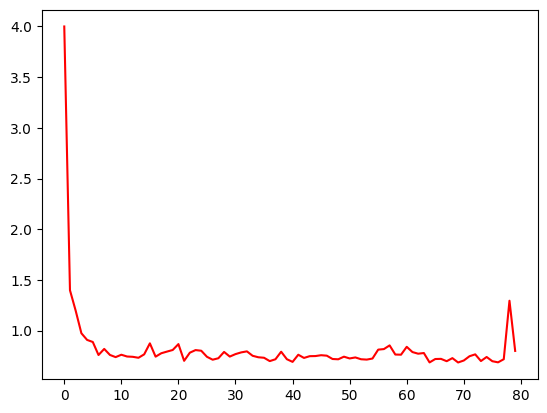

In [88]:
# Epoch loop
n_epochs = 80
Loss=[]
n = len(dataset)
#t = tqdm(enumerate(loader), total=total, leave=leave)



t = tqdm(range(0, n_epochs))

for epoch in t:

#for epoch in range(n_epochs):
    print(f'start of epoch: {epoch+1}/{n_epochs}')
    loss = train(
        model,
        optimizer,
        loader,
        n,
        batch_size,
        leave=(epoch == n_epochs - 1),
    )
    #print(f'loss: {loss}')
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    Loss.append(loss)




matplotlib.pyplot.plot(np.array(Loss), 'r')

FAire une explication de T1 et T2

In [68]:
t = enumerate(loader)
for i, batched_data in t:
    print(i,batched_data)
    print('batched_data.T',batched_data.T)

    T1 = []
    for j in range(len(batched_data.T)):
        T1.extend([j] * int(batched_data.T[j].item()))  
    batched_data.T = torch.tensor(T1, device=device)
    #print('batched_data.T1',batched_data.T)
    #print('len(batched_data.T1)',len(batched_data.T))



    T2=[]
    for w in range(len(batched_data)):
        T2.extend([w] * deepset_size)
    batched_data.T2 = torch.tensor(T2, device=device)
    #print('batched_data.T2',batched_data.T2)

    data=model(batched_data)

    #print('data.edge_attrwtilde_45',data.edge_attrwtilde[45])
    #print('data.edge_attr1_45',data.edge_attr1[45])

    print('data',data)



    

0 DataBatch(x=[608, 1], edge_index=[2, 5162], edge_attr1=[5162, 1], T=[6], y=[4], batch=[608], ptr=[3])
batched_data.T tensor([110., 110., 105.,  84., 120.,  79.])
data tensor([-12.8398,  -2.1347, -14.3863,  -2.2924], grad_fn=<ViewBackward0>)
1 DataBatch(x=[549, 1], edge_index=[2, 4469], edge_attr1=[4469, 1], T=[6], y=[4], batch=[549], ptr=[3])
batched_data.T tensor([ 80.,  84.,  95., 104.,  98.,  88.])
data tensor([ -9.8145,  -1.0584, -12.7682,  -1.5913], grad_fn=<ViewBackward0>)


### Mapping layer

### Création d'un dataset pytorch

In [ ]:

class GraphSetDataset(Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        return self.datalist[idx]


### Fonction collate pour gérer l'assemblage des graphes lors du batching

Dans la même idée que merge_components on s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

En effet lors du batching le loader de PyG fait des données (qu'il suppose être des graphes simples) d'un même batch un gros graph à composante non connexes.



In [ ]:


def collate_fn(batch):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    labels = torch.empty(len(batch),2)
    
    for allset, label in batch:
        labels.append(label)
        x_list.append(allset.x)
        edge_index_list.append(allset.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(allset.edge_attr)
        num_nodes_offset += allset.num_nodes


    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    labels = torch.tensor( labels,dtype=torch.float32)

    return graph, labels


# Définition training